In [32]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

### Импортируем данные 
##### обучающая выборка (train_data) - 2011 год — последний торговый день 2020 года
##### тестовая выборка (test_data) - первый торговый день 2021 года - последний торговый день 2021 года
##### выборка для финального расчета результатов модели (final_data) - первый торговый день 2022 года - 11 мая 2022 года

In [34]:
stocks = pd.read_csv('stock_data.csv')
stocks['date'] = pd.to_datetime(stocks['date'])
train_data = stocks[ stocks['date'] >= '2011-01-01' ]
train_data = train_data[ train_data['date'] < '2021-01-01' ]
test_data = stocks [ stocks['date'] >= '2021-01-01' ]
test_data = test_data[ test_data['date'] < '2022-01-01' ]
final_data = stocks [ stocks['date'] >= '2022-01-01' ]
final_data = final_data[ final_data['date'] < '2022-05-11' ]

#### Следует узнать количество тикеров:

In [35]:
tickers = np.array(stocks['ticker'].unique())
tickers.size

4714

#### Итерироваться по $\frac{4714(4714-1)}{2}$ возможным парам придется очень долго для подбора подходящих пар,  поэтому постараемся оставить только акции с выскокой ликвидностью:

In [36]:
minimal_liq = 0.89
t = train_data[ train_data['turnover'] > minimal_liq ]
tickers = t['ticker'].unique()
tickers.size

75

#### Пар теперь не так много, далее будем отбирать подходящие пары активов. Будем работать с корректированной (эджастированной) ценой
#### В датасете был дан qfq_factor, с помощью которого и можно получить корректированную цену. 
#### В процессе итераций выберем пары с корреляцией выше corr_value, далее проведем тест Дики-Фуллера на стационарность процесса $\log P_{1}^{t}-\gamma\log  P_{2}^{t} $ , где $\gamma\$ можем получить с помощью МНК. Стоит отметить, что не все хорошо коррелированные пары являются коинтегрированными, потому и проводим тест Дики-Фуллера
#### Результаты занесем в датафрейм result, где будем хранить данные, нужные для последующей работы:

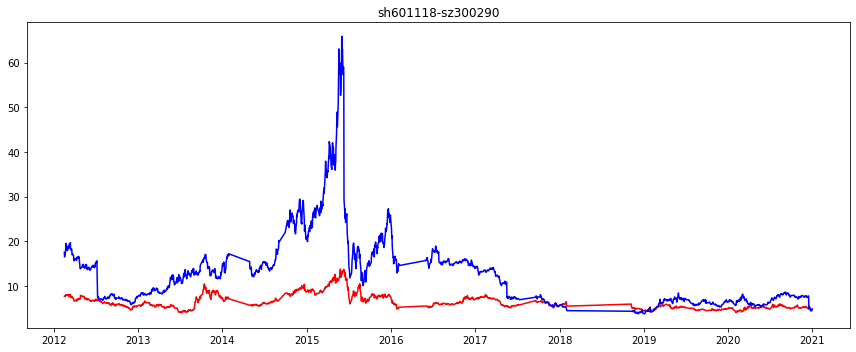

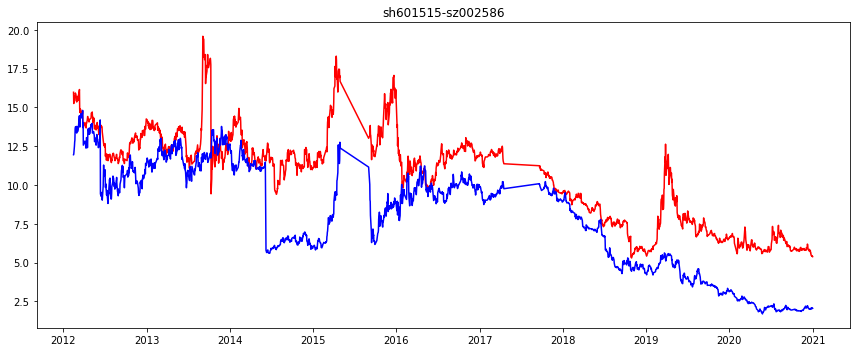

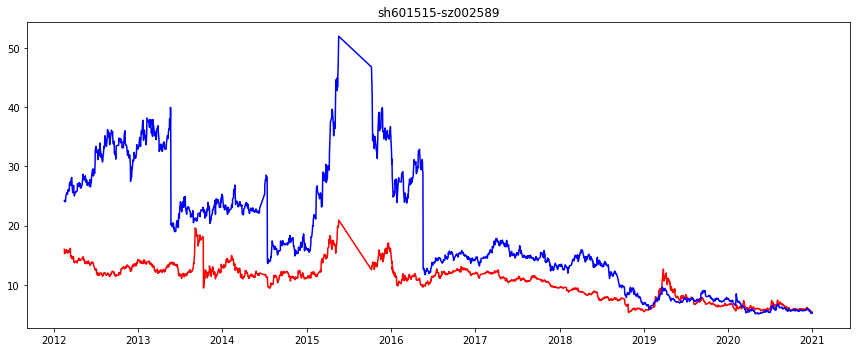

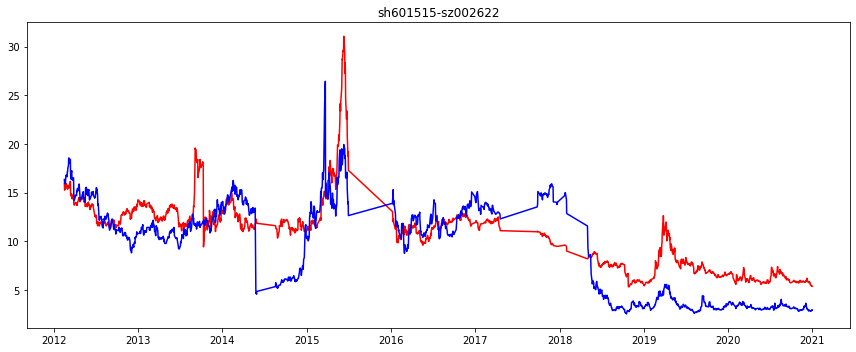

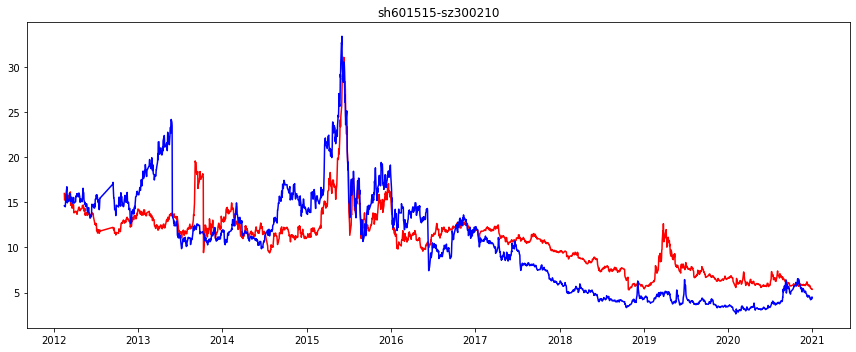

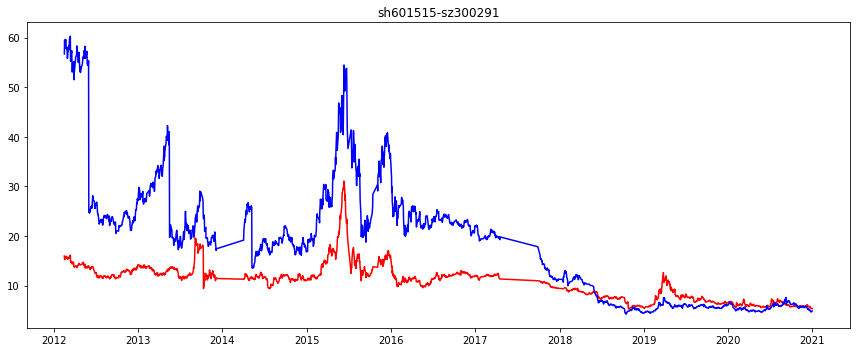

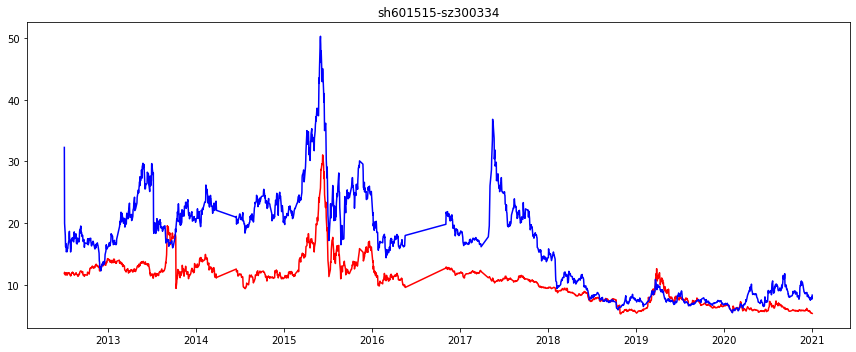

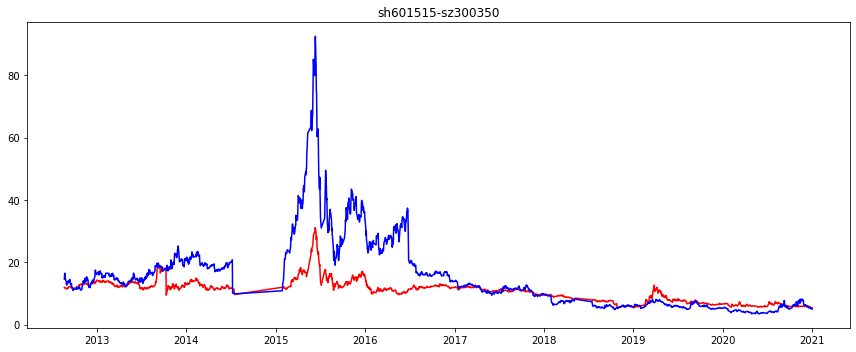

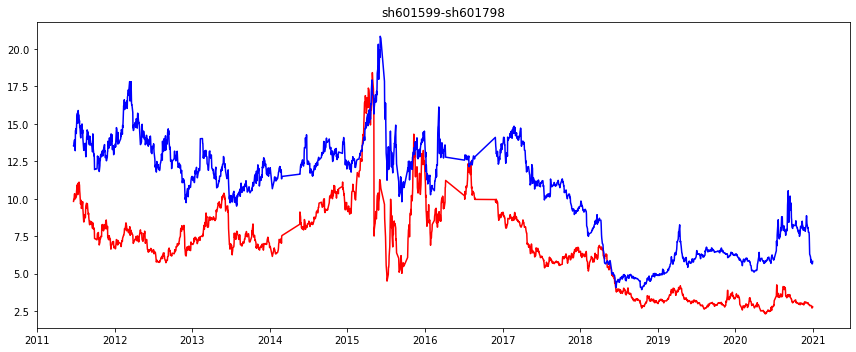

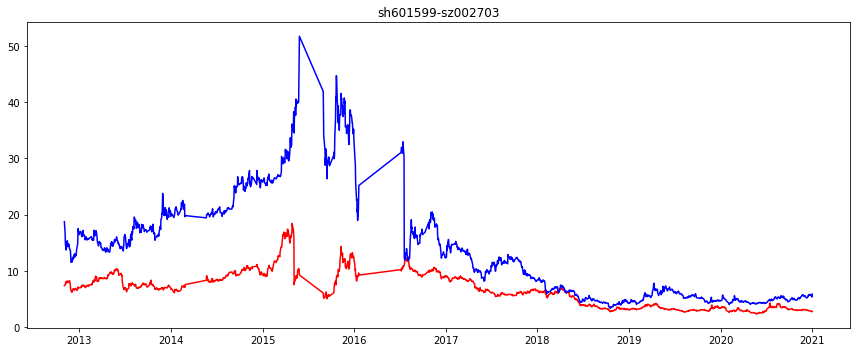

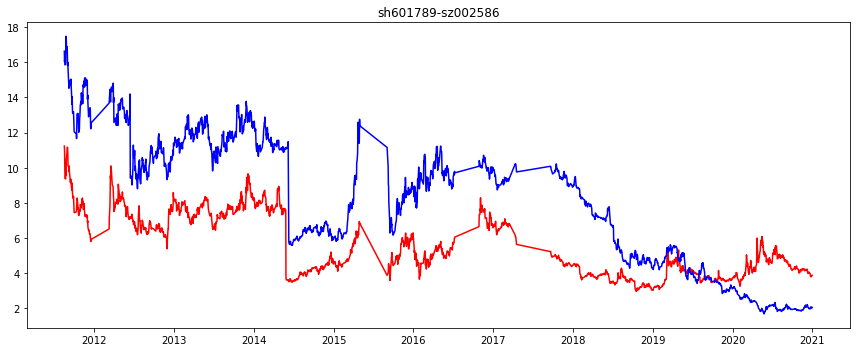

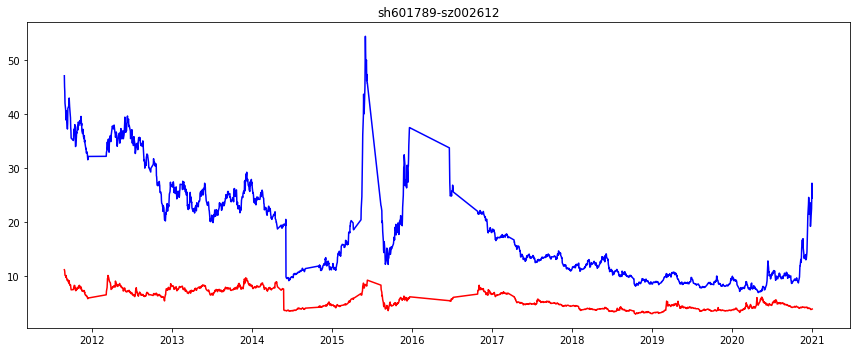

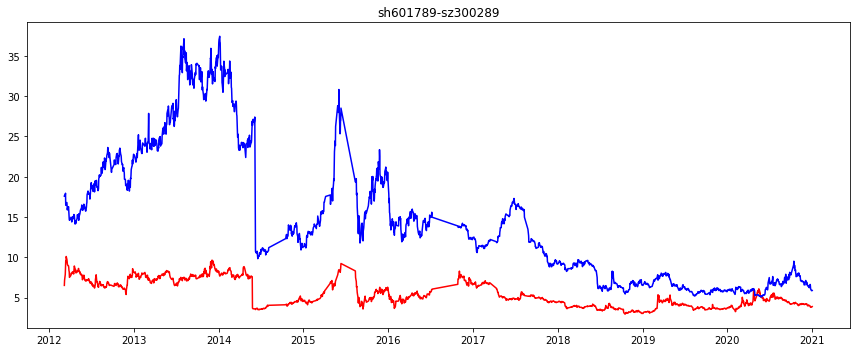

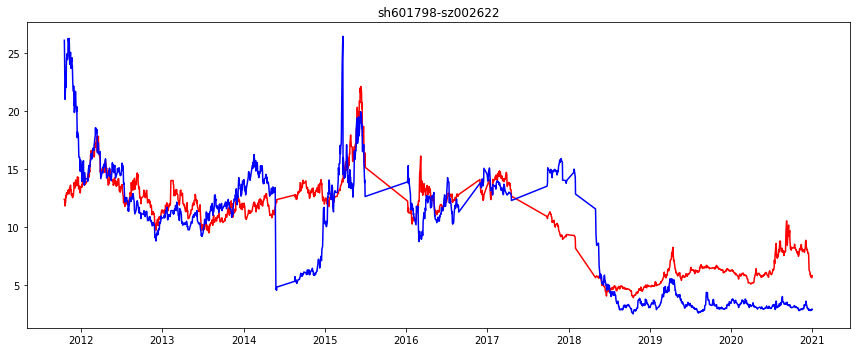

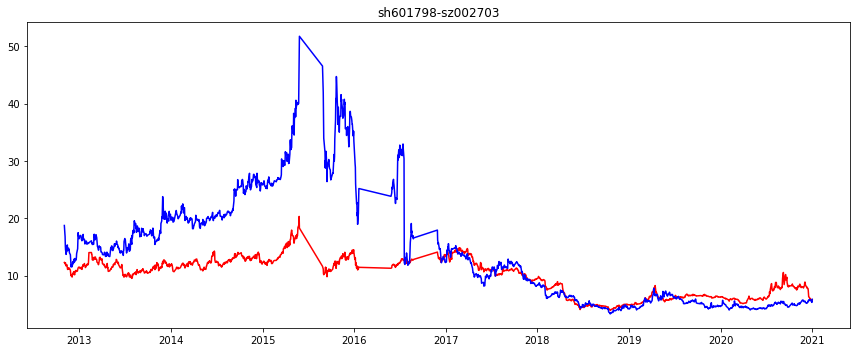

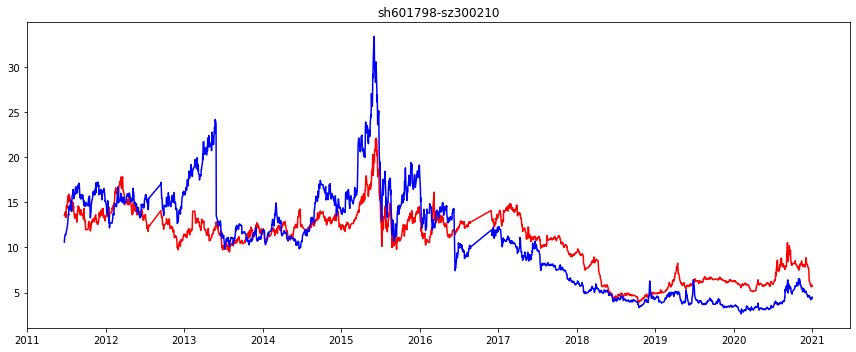

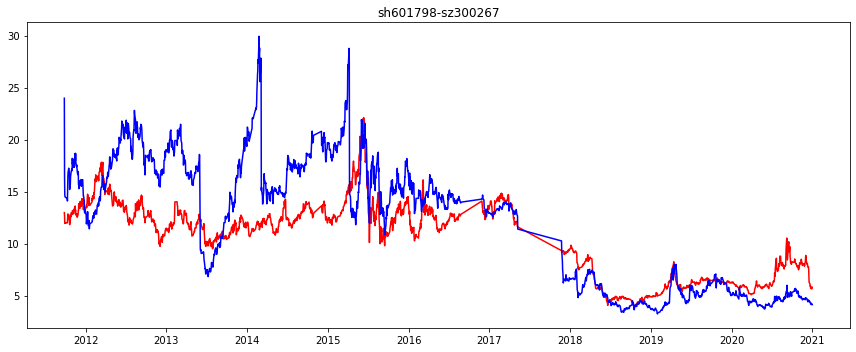

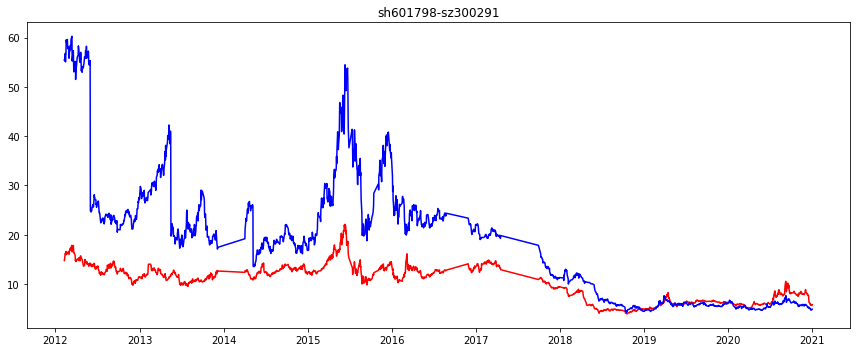

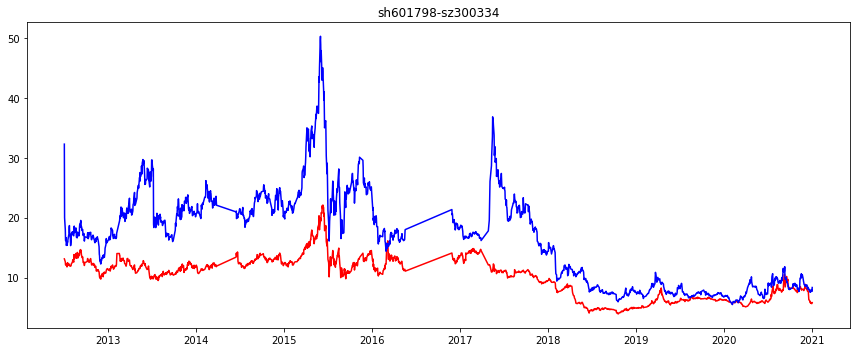

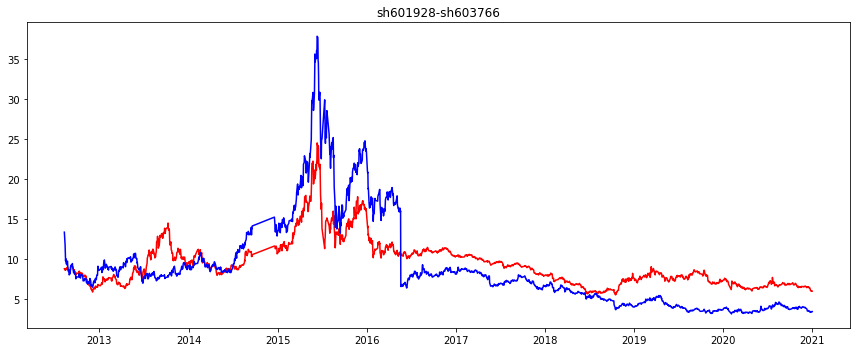

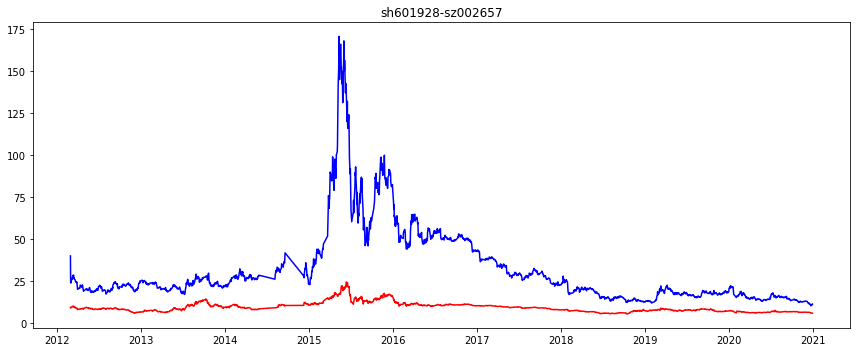

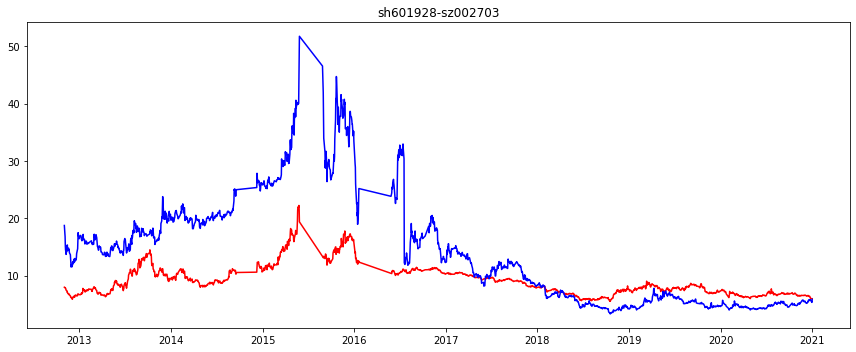

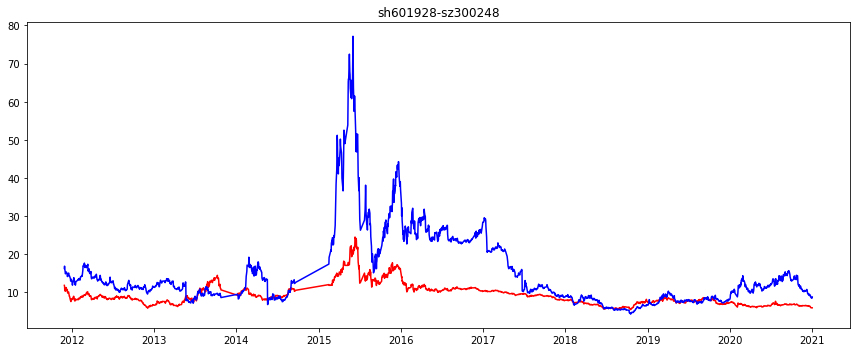

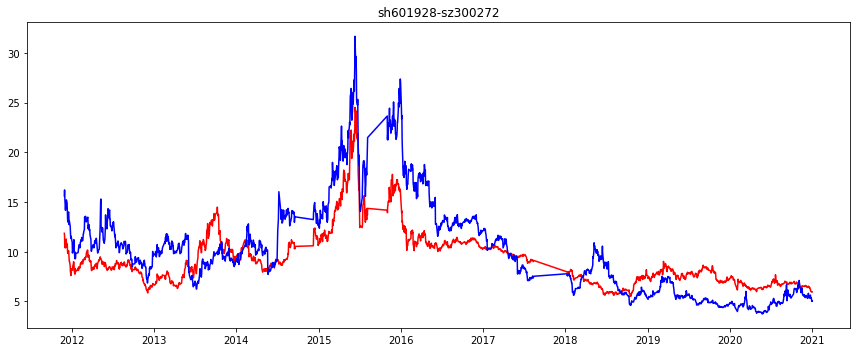

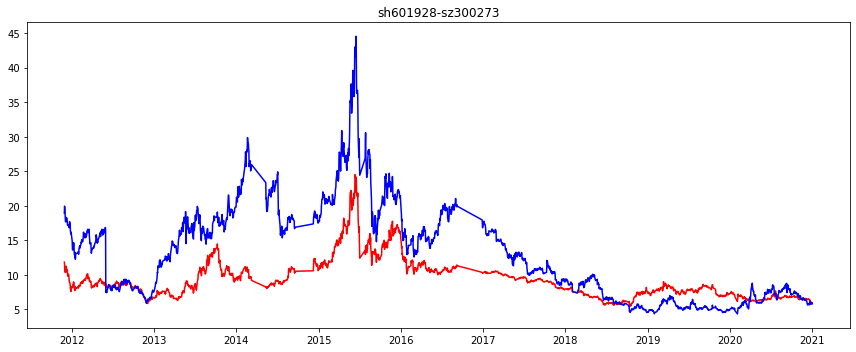

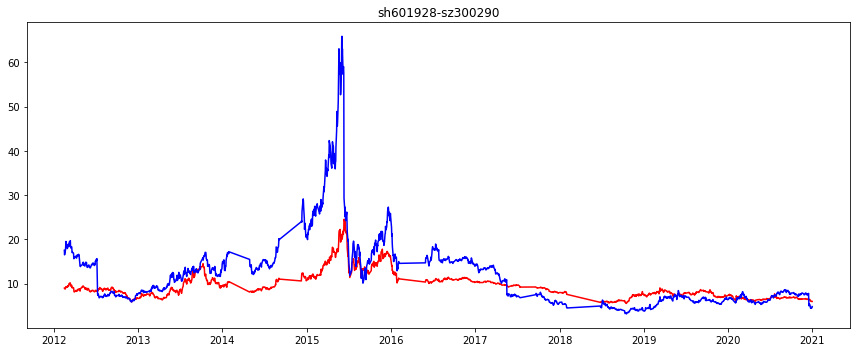

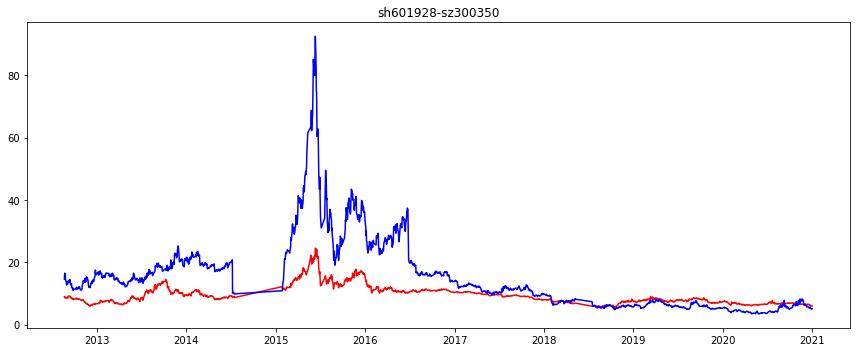

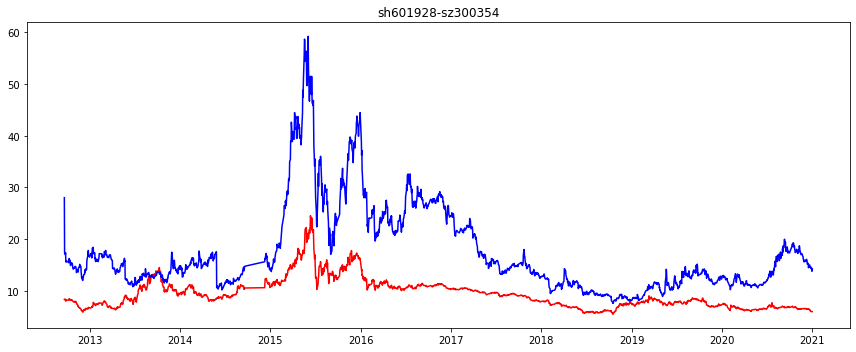

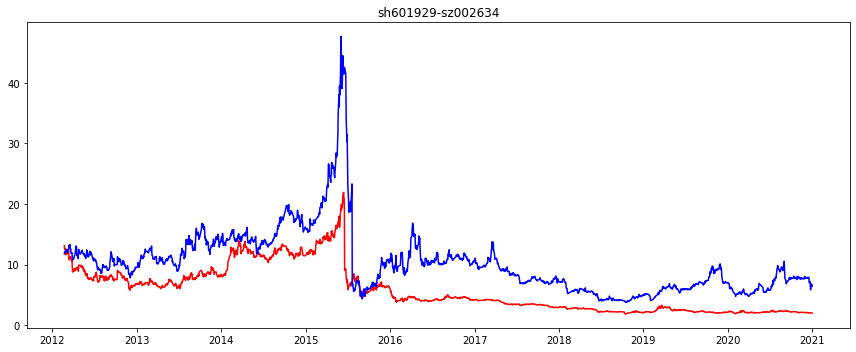

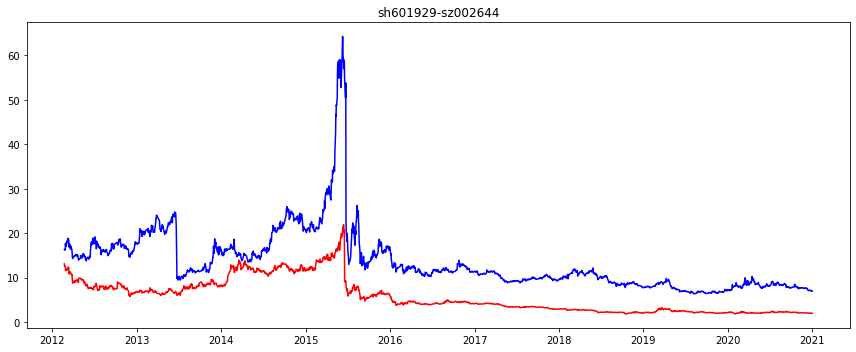

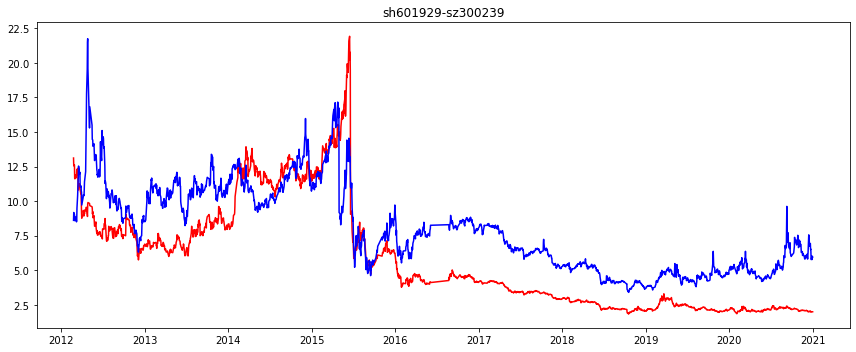

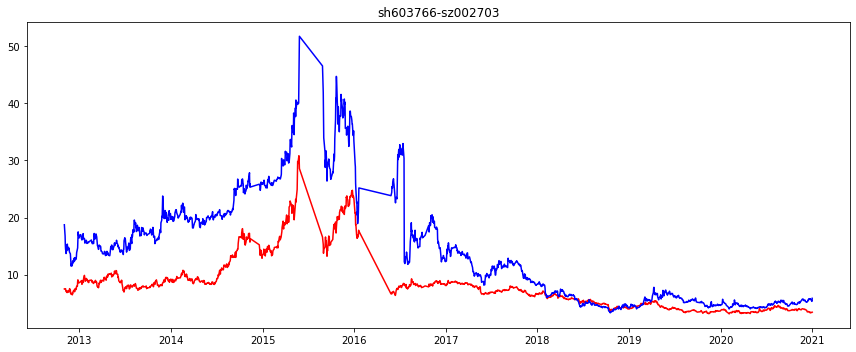

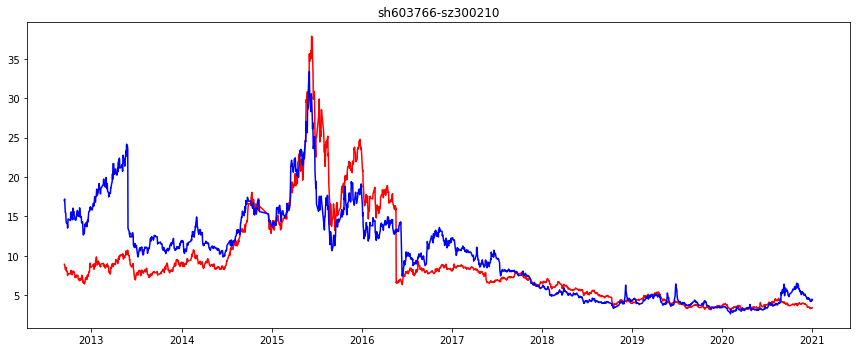

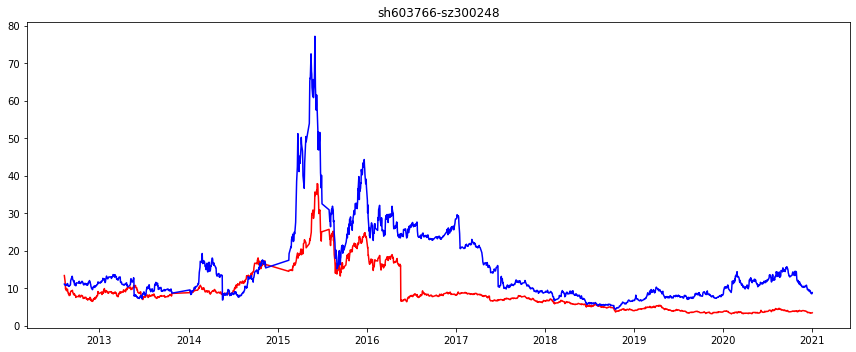

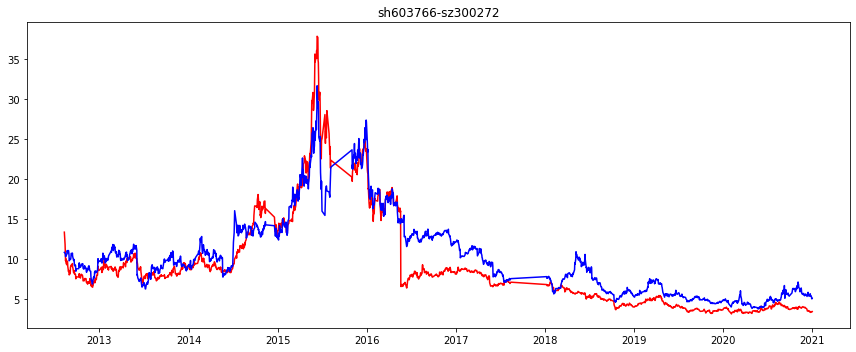

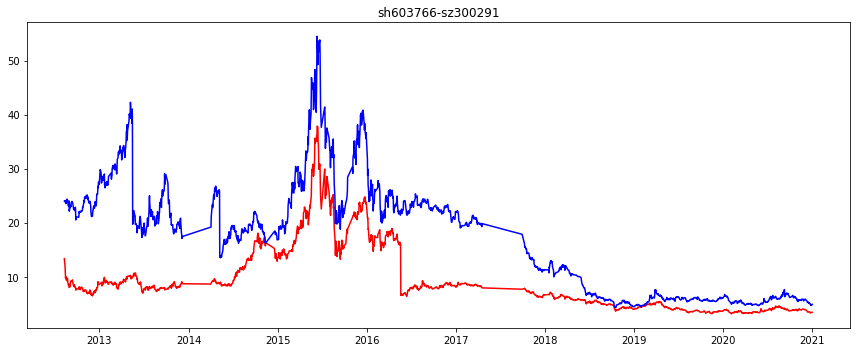

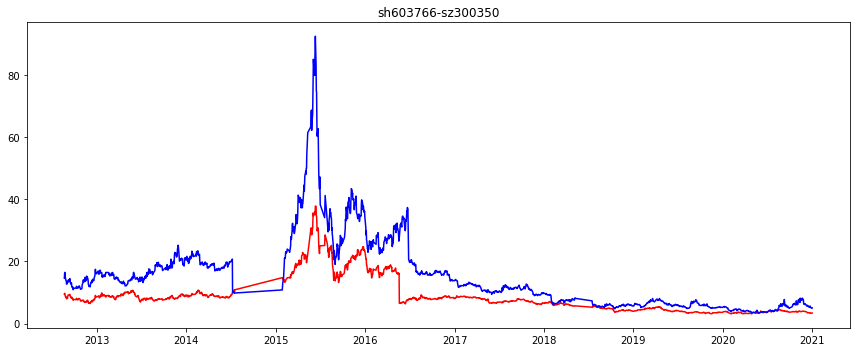

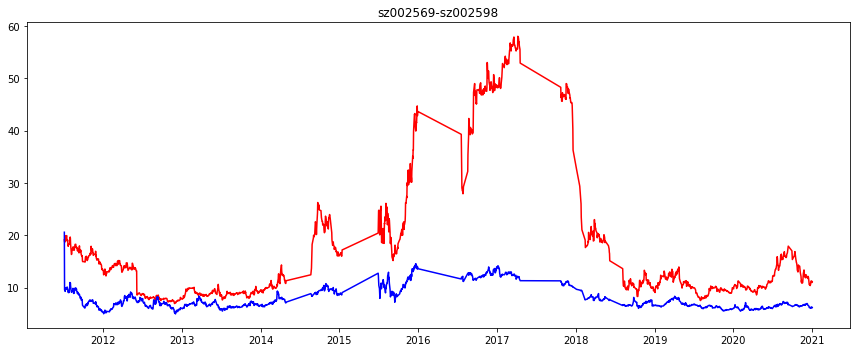

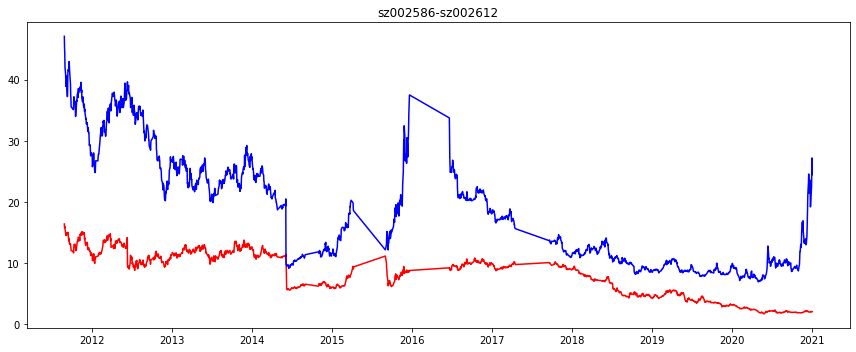

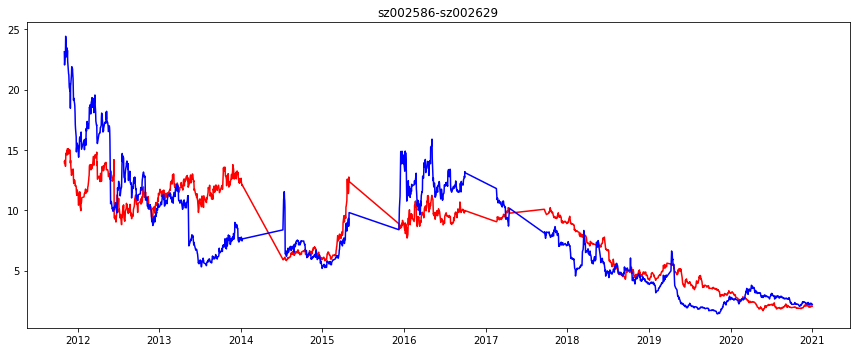

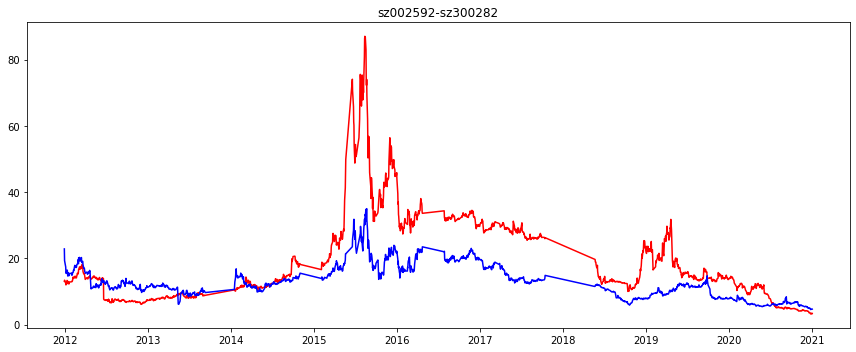

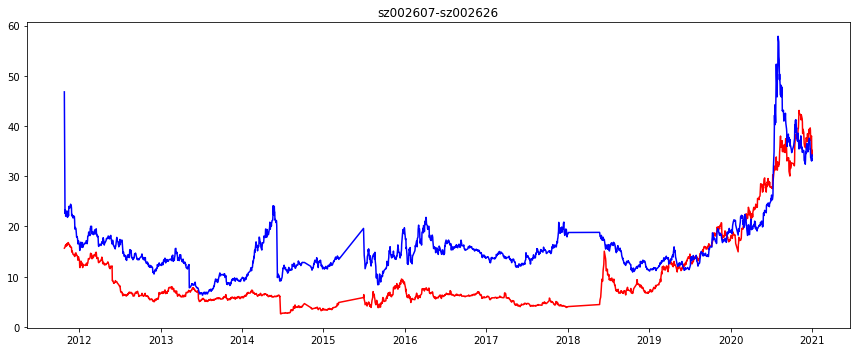

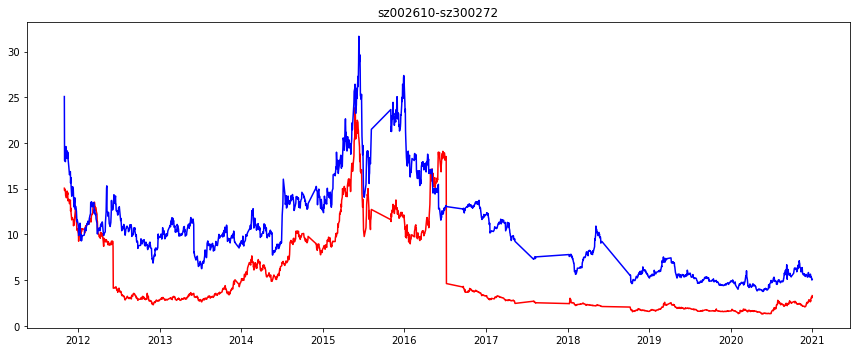

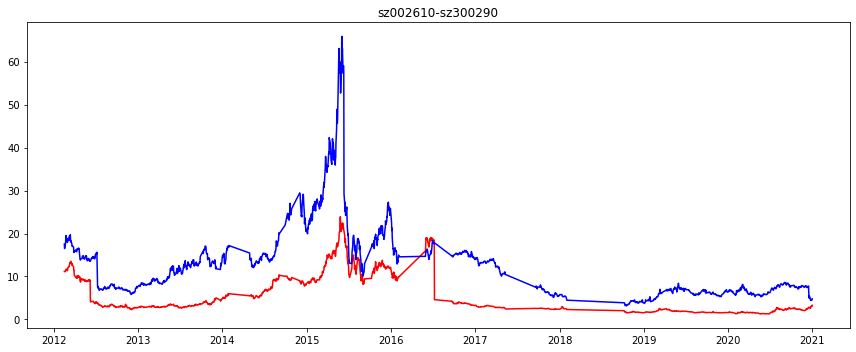

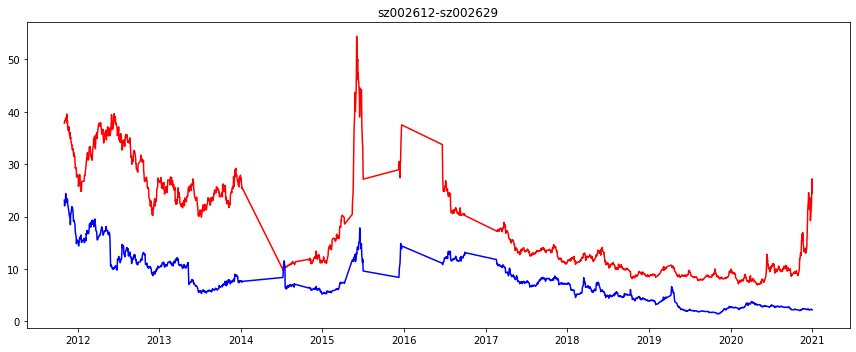

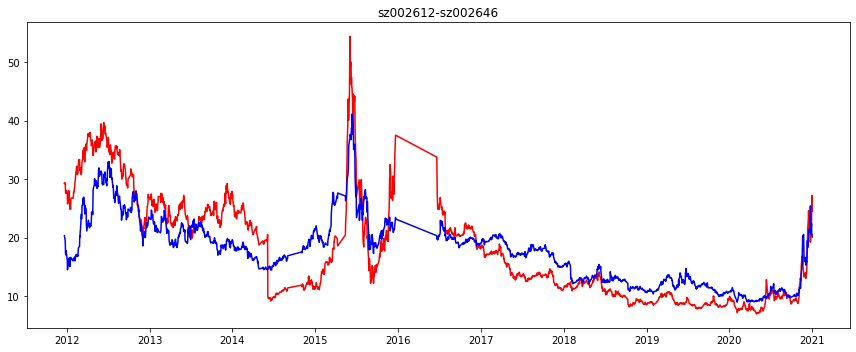

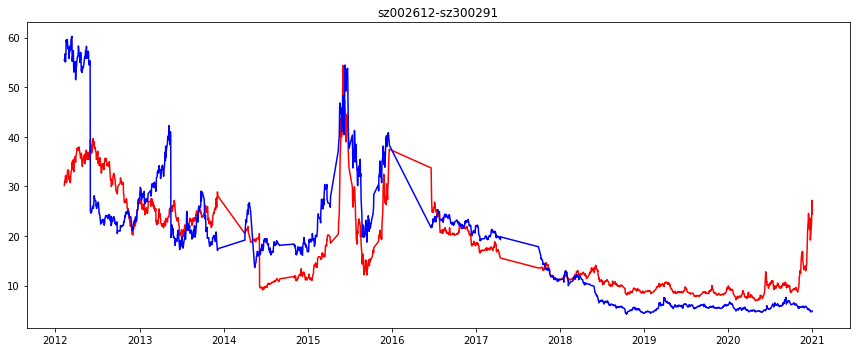

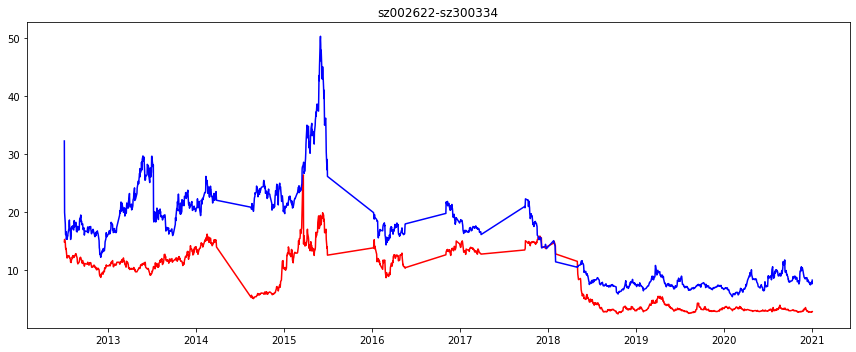

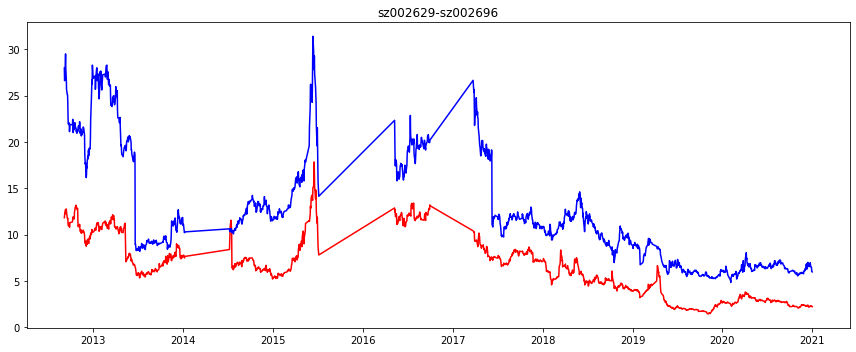

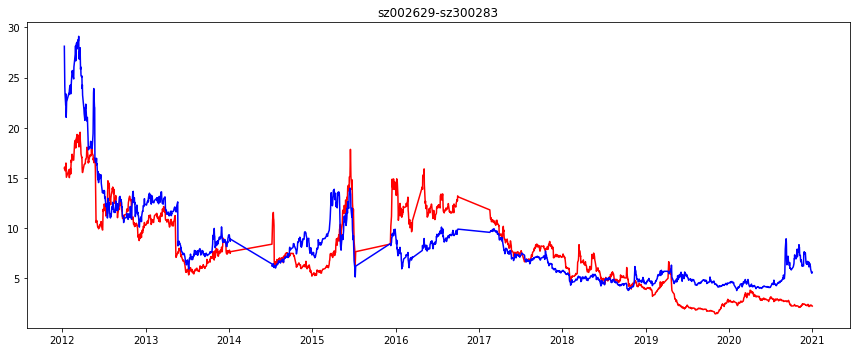

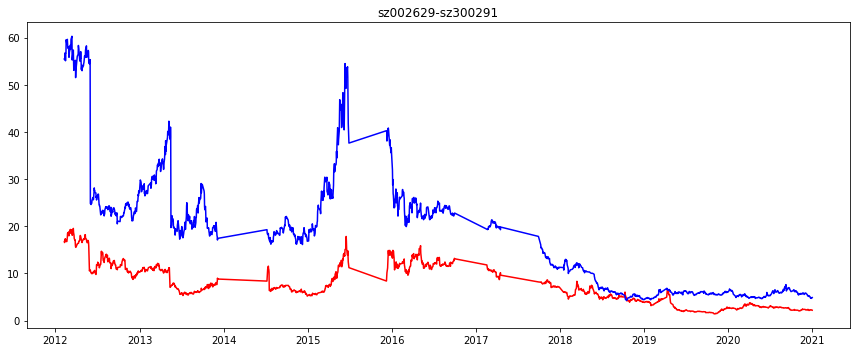

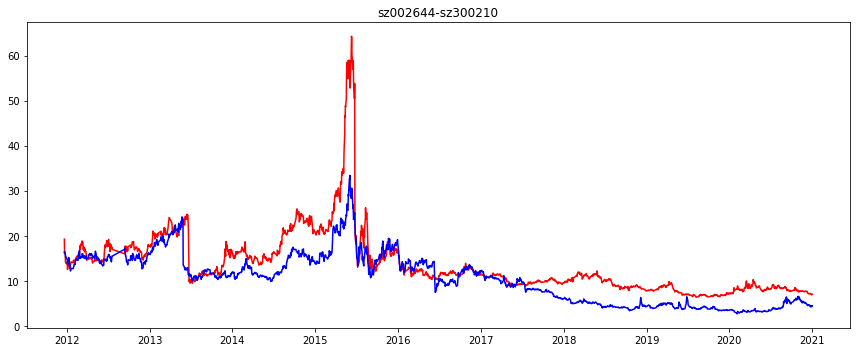

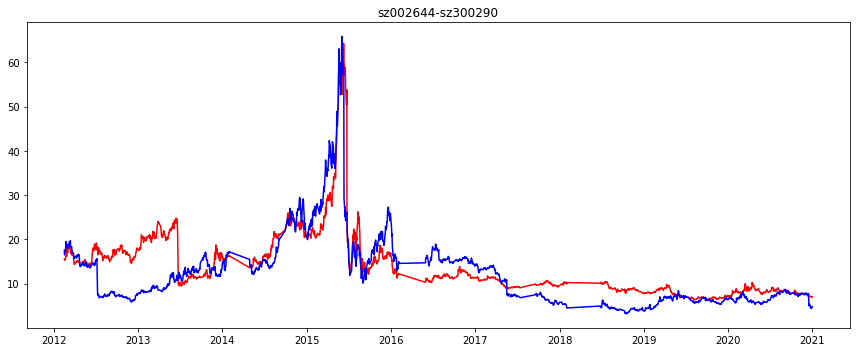

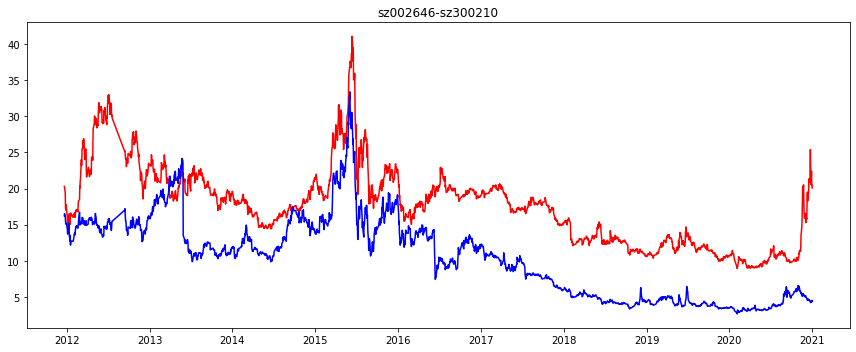

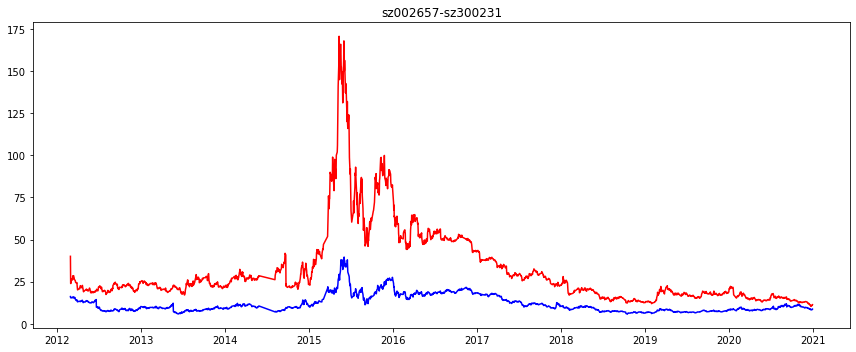

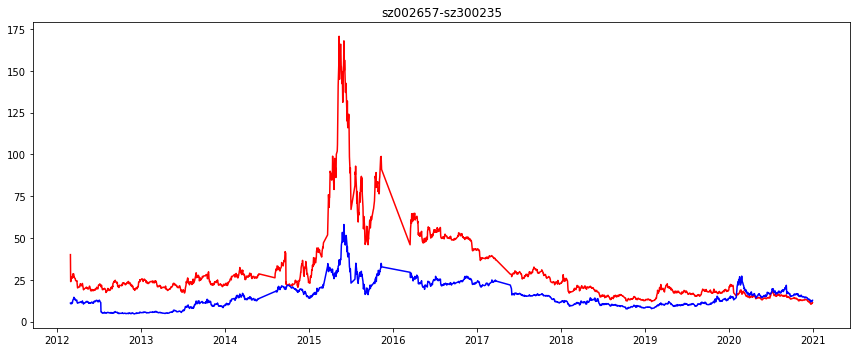

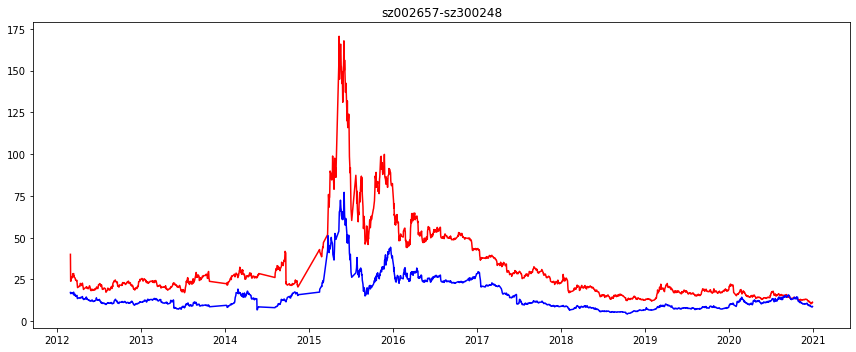

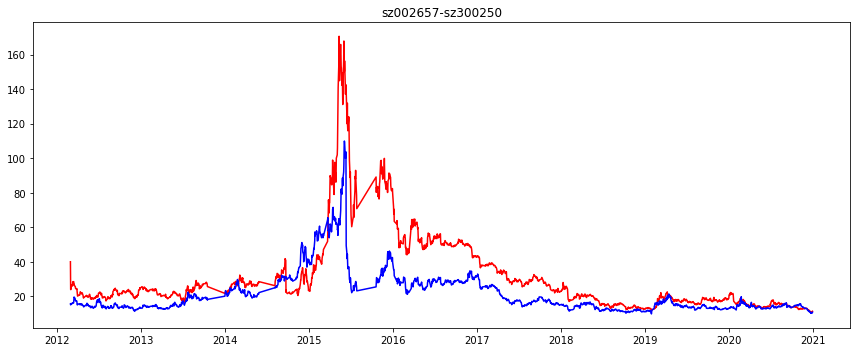

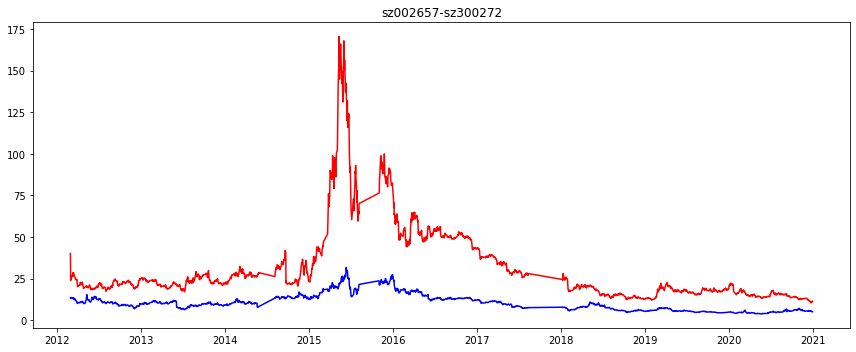

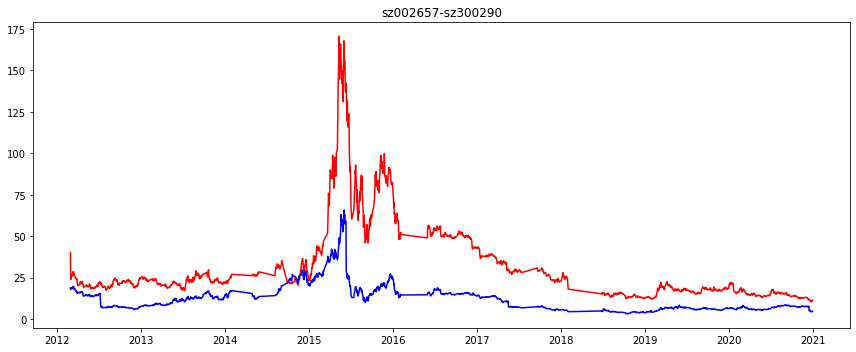

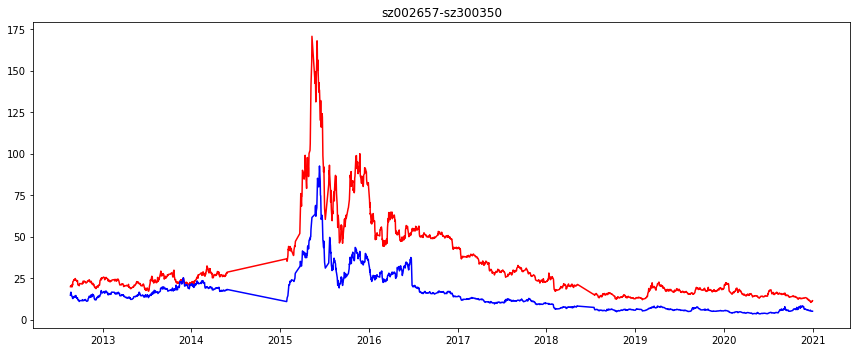

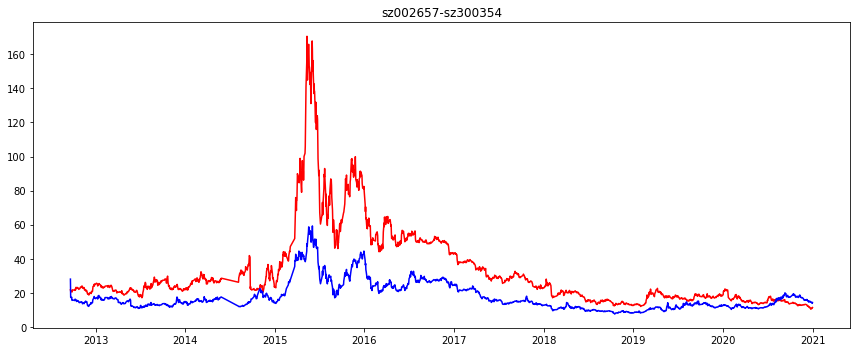

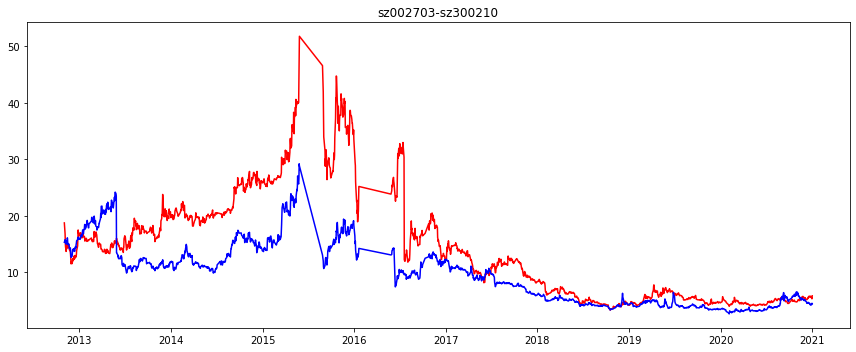

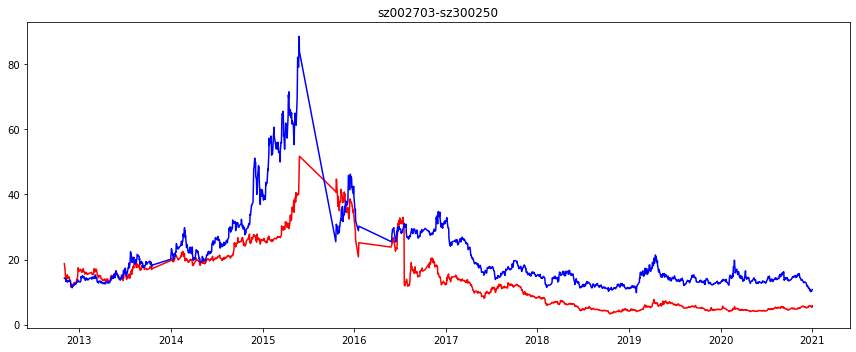

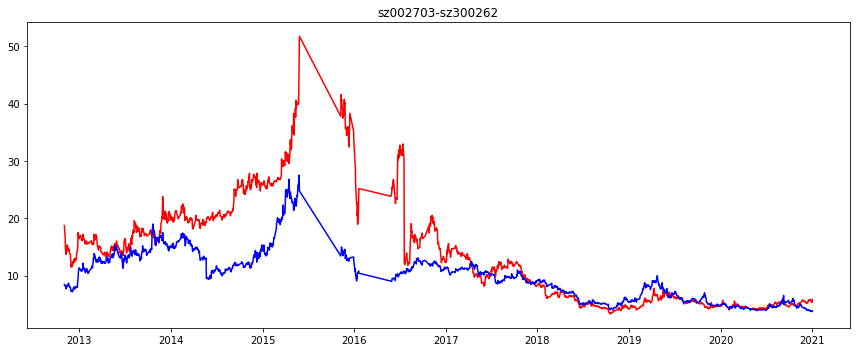

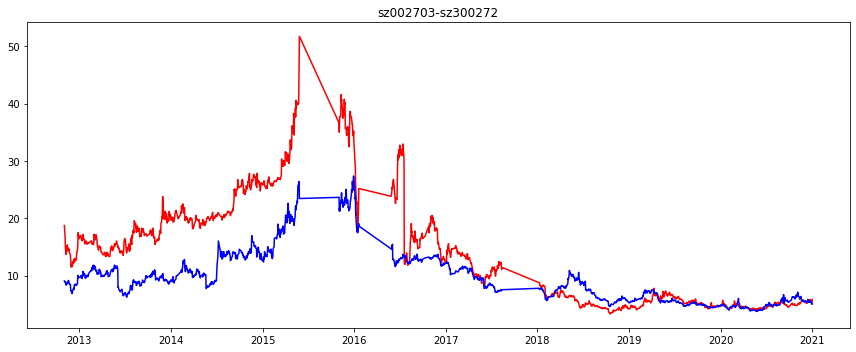

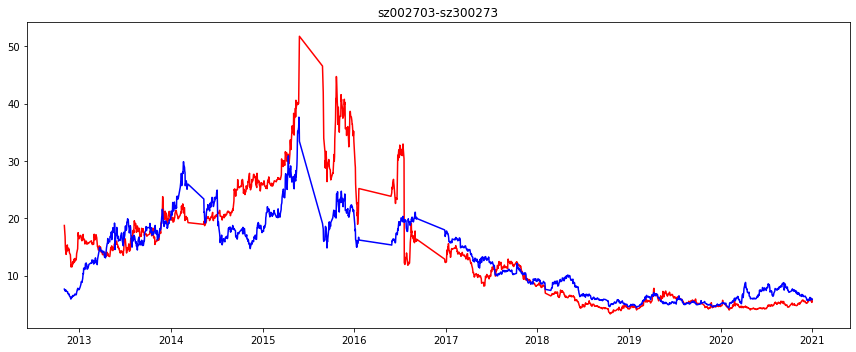

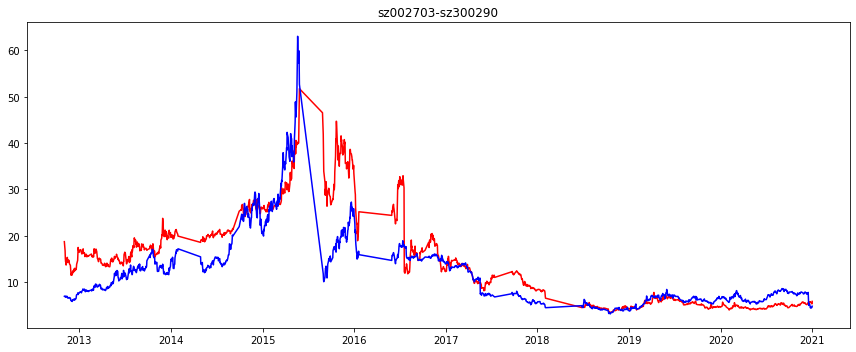

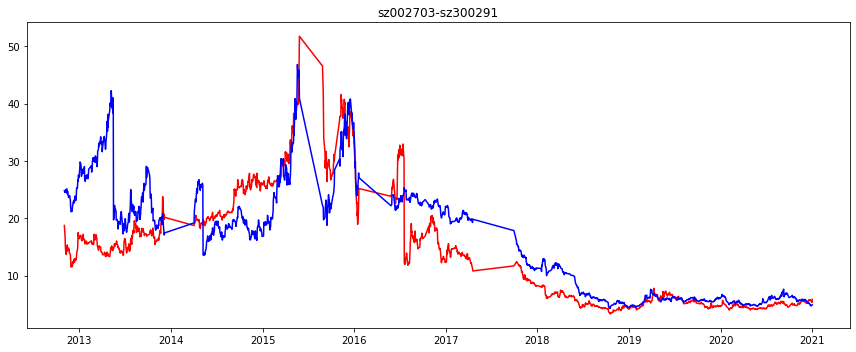

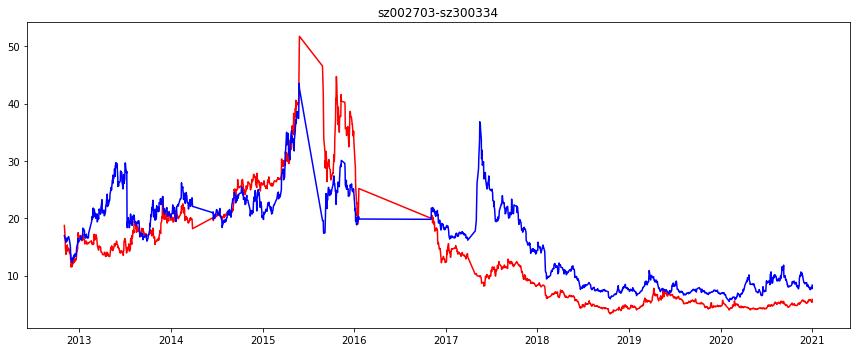

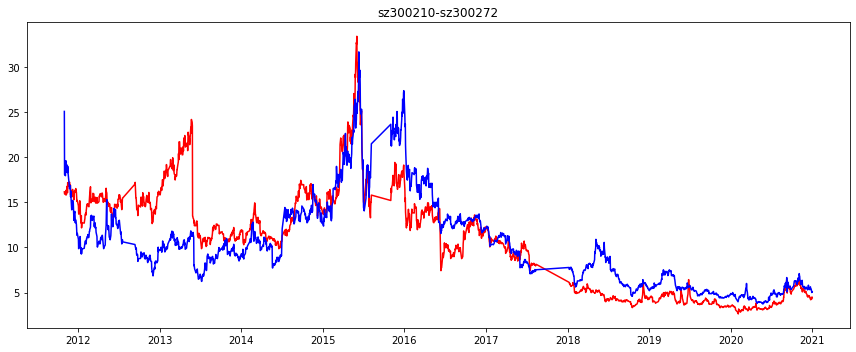

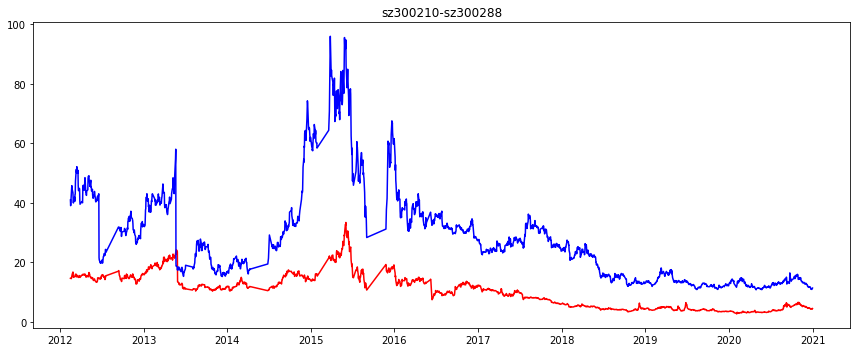

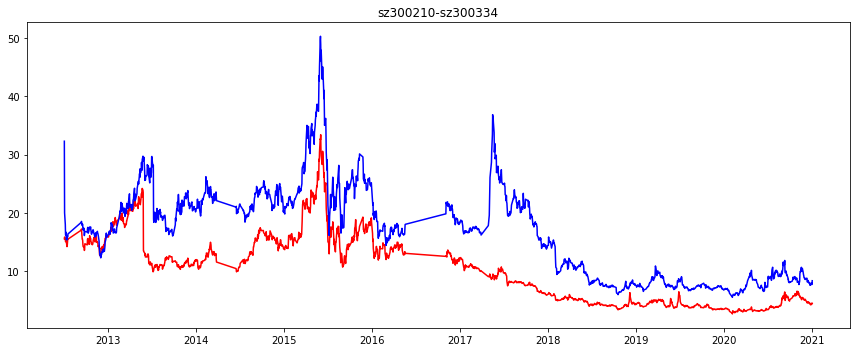

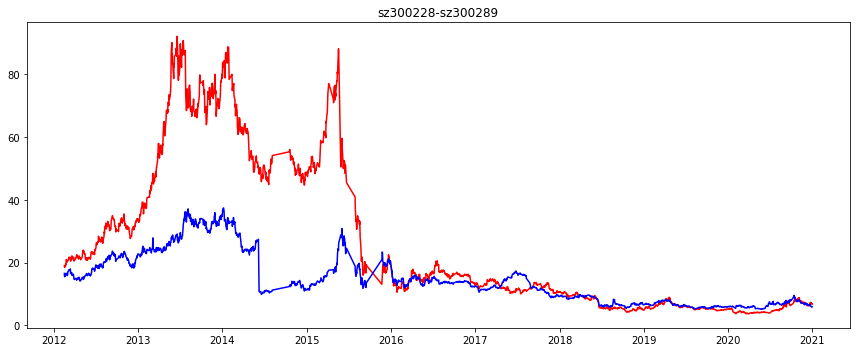

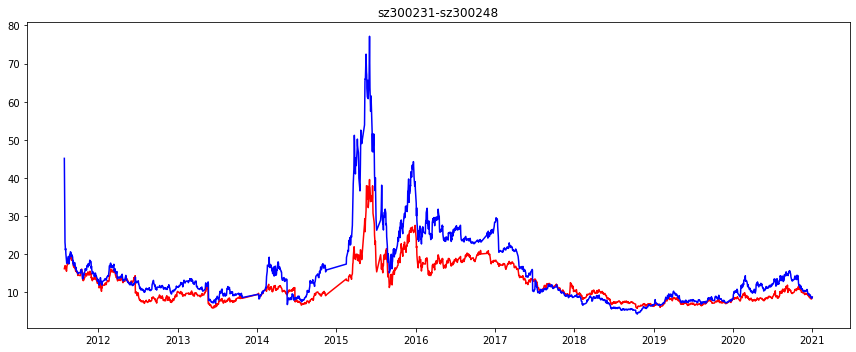

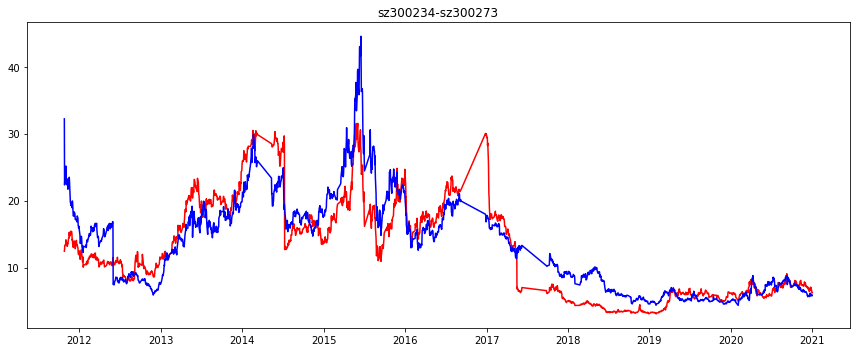

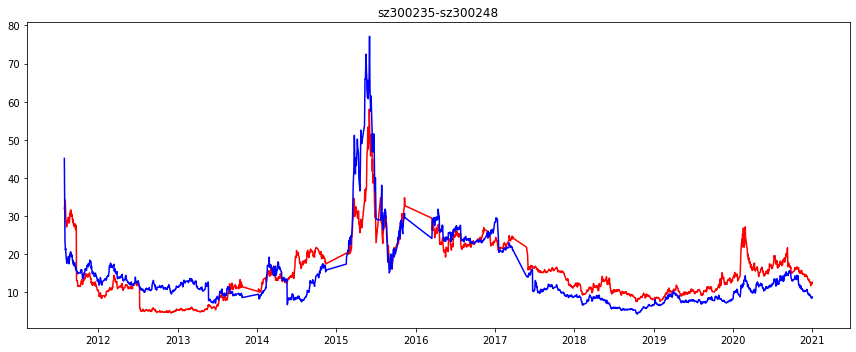

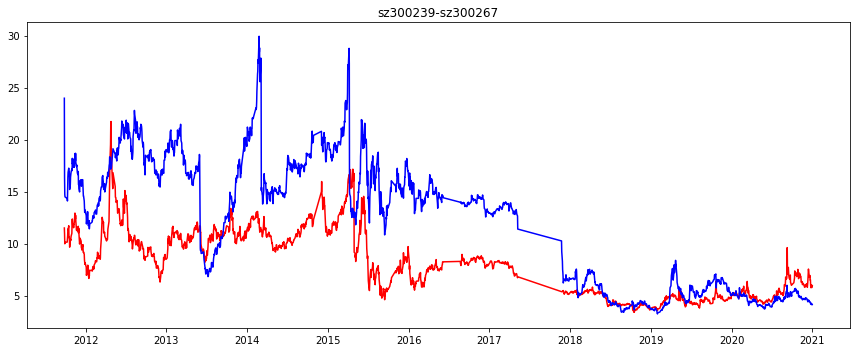

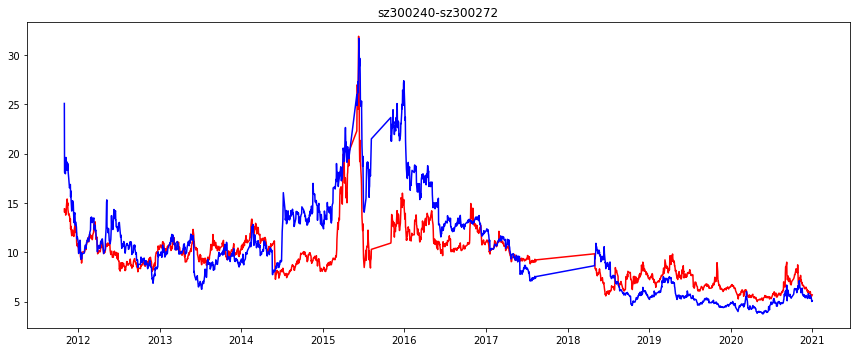

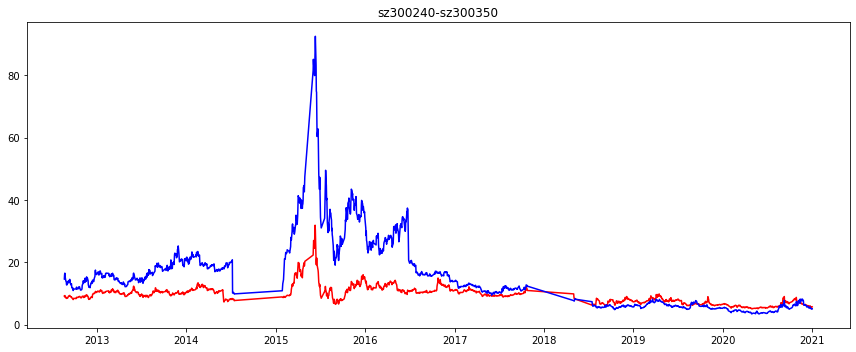

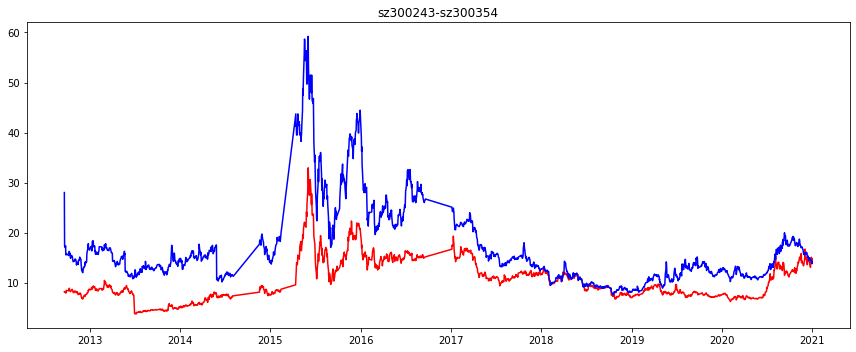

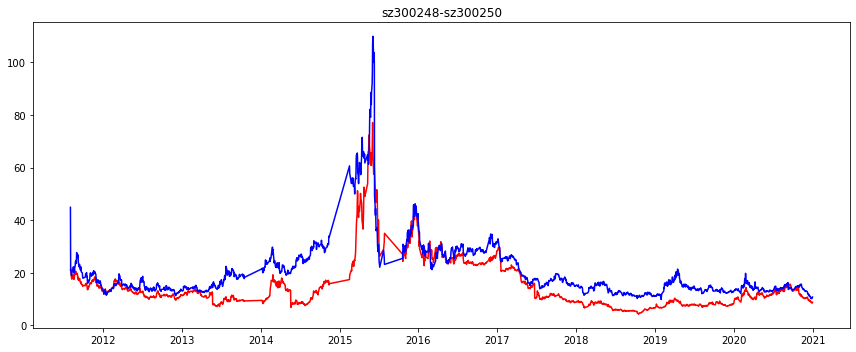

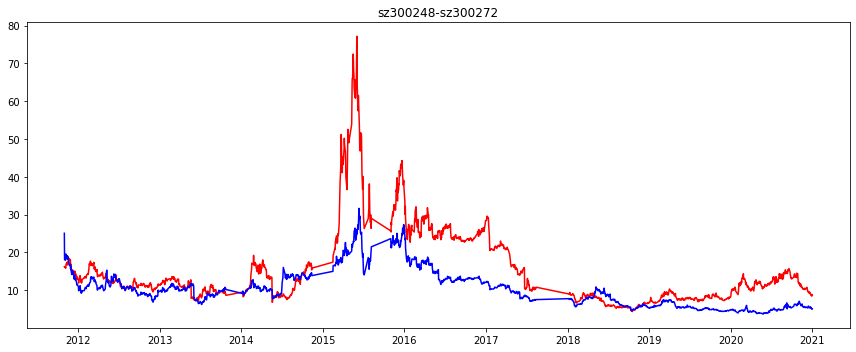

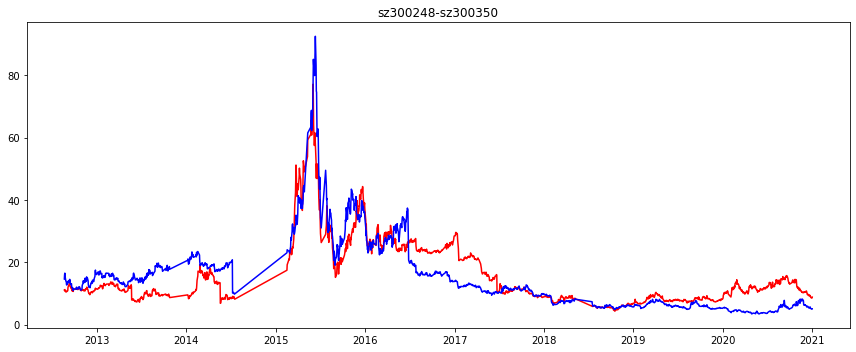

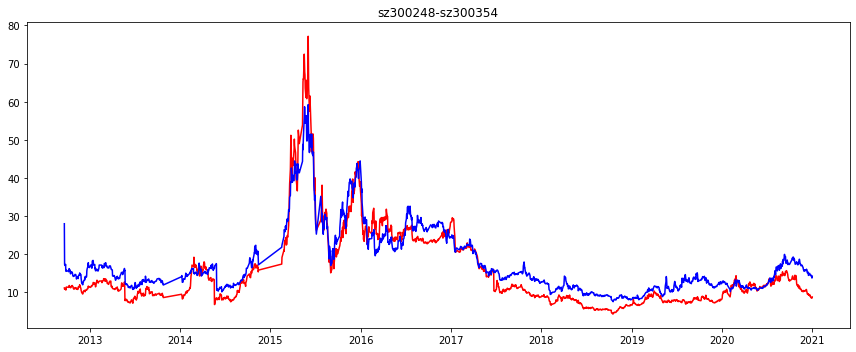

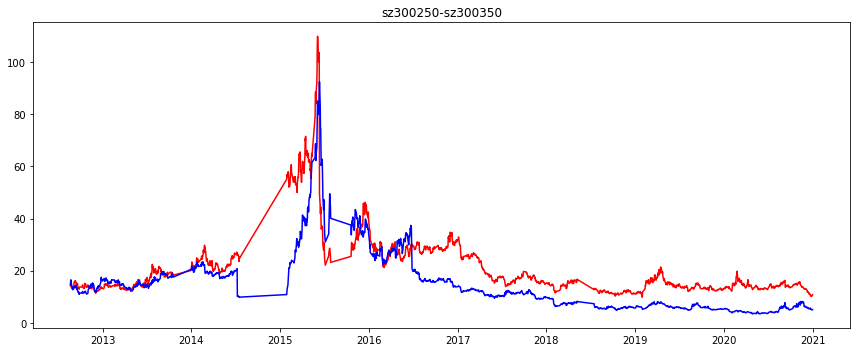

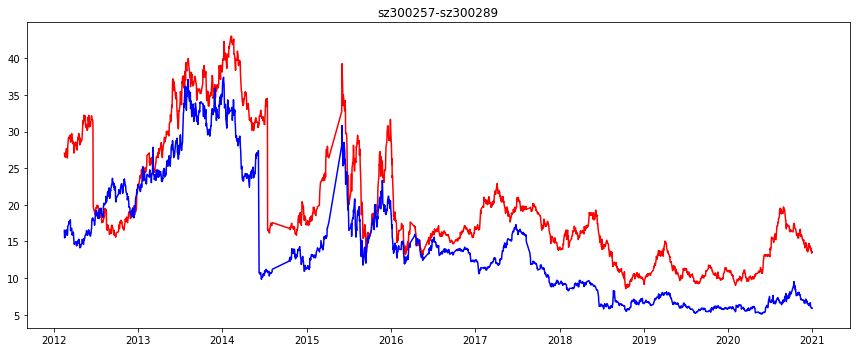

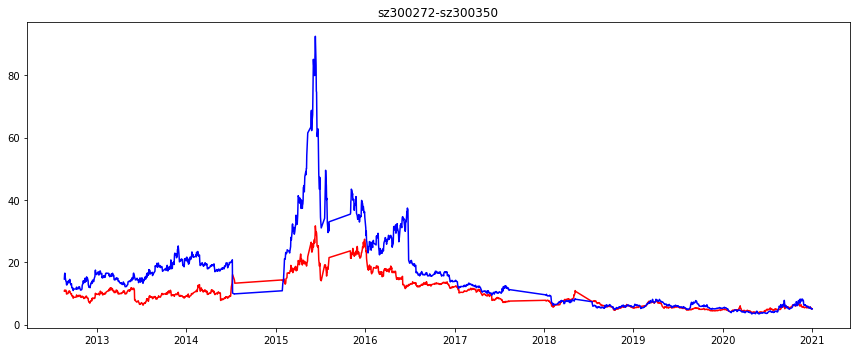

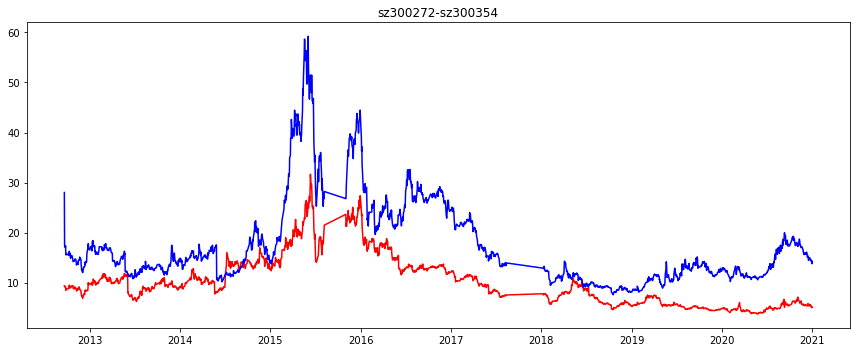

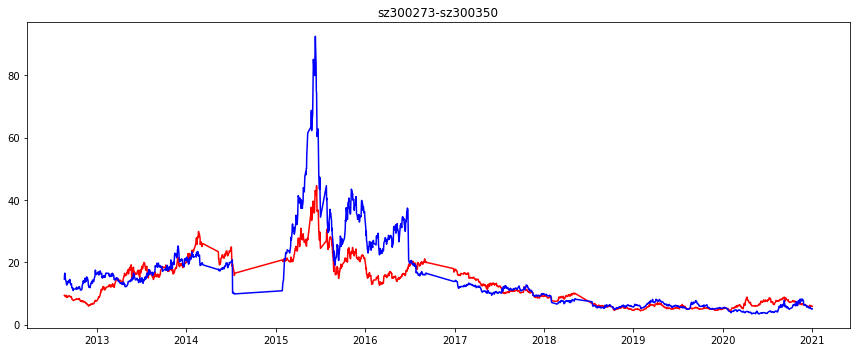

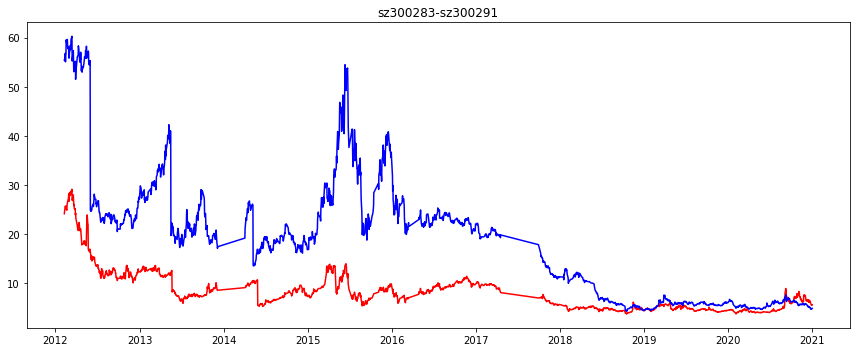

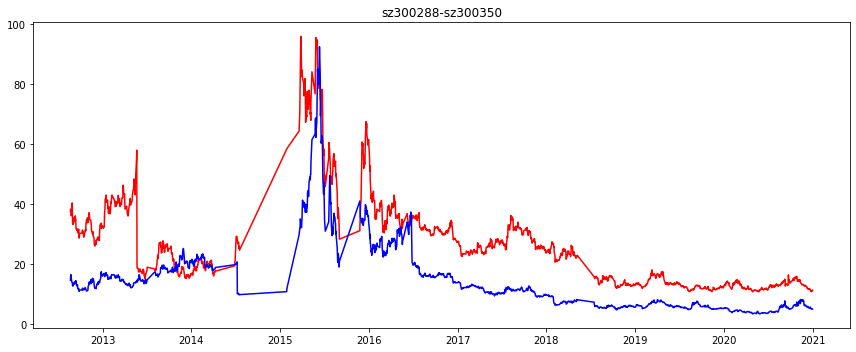

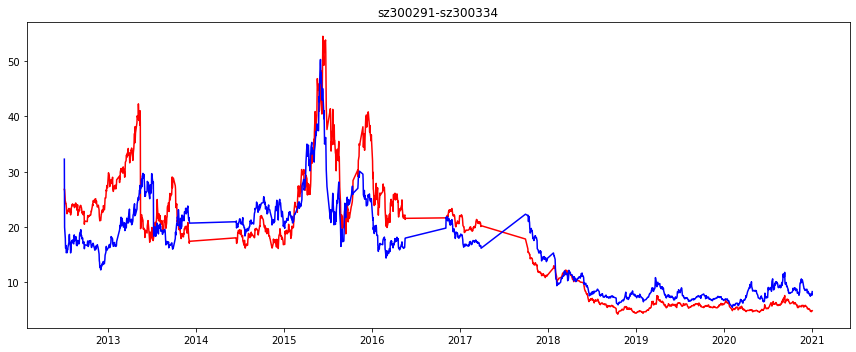

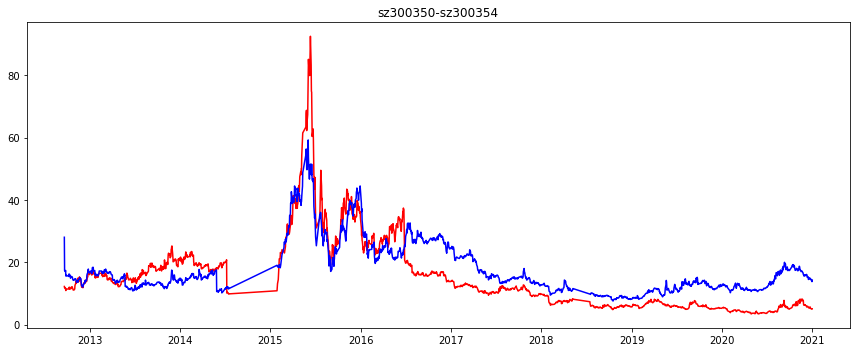

In [37]:
corr_value = 0.81
dates = train_data['date']
result = pd.DataFrame(np.empty((0, 7)))
result.columns  = ['ticker_1', 'ticker_2', 'index_1', 'index_2', 'correlation', 'stderr_in_linregress', 'slope']
for i in range(tickers.size):
    boolean = False 
    for j in range(tickers.size):
        if (i < j):
            p1 = train_data[ train_data['ticker'] == tickers[i] ]
            p2 = train_data[ train_data['ticker'] == tickers[j] ] 
            
            #Будем работать с эджастированной ценой
            p1 = pd.DataFrame( {'date' : p1['date'], 'adjusted' : p1['close'] * p1['qfq_factor'] } )
            p2 = pd.DataFrame( {'date' : p2['date'], 'adjusted' : p2['close'] * p2['qfq_factor'] } )
              
            #Исключаем те, что не торговались в последний торговый день
            if ( p1[ p1['date'] == '2020-12-31' ].size == 0):
                boolean = True 
                continue 
            if ( p2[ p2['date'] == '2020-12-31' ].size == 0):
                continue
            
            #Сопостовляем данные по дате так, чтобы гарантированно не было сдвигов 
            merged = pd.merge(p1, p2, on = "date", suffixes = ('_p1', '_p2'))
            
            if ( merged.size != 0 ): 
                #Ищем корреляцию 
                correlation = np.corrcoef( np.array(merged['adjusted_p1']), np.array(merged['adjusted_p2']) )
                if ( abs(correlation[0,1]) >= corr_value): 
                    slope, intercept, rvalue, pvalue, stderr = sps.linregress( np.log( merged['adjusted_p1'] ), np.log( merged['adjusted_p2'] ) ) 
                    
                    # log(p1) = a * log(p2) + b
                    # a - slope, b - intercept 
                    #do Engle's and Grangers' test with using Fuller's statistics 
                    eps_spread = np.log( merged['adjusted_p1'] ) - slope * np.log( merged['adjusted_p2'] )
                    df_test = adfuller( eps_spread )
    
                    if ( df_test[0] > df_test[4]['5%'] ): #df test is done 
                        result = result.append({'ticker_1' : tickers[i], 'ticker_2':tickers[j], 'index_1': i, 'index_2': j, 'correlation': correlation[0,1], 'stderr_in_linregress': stderr, 'slope': slope , 'std_eps':eps_spread.std(), 'exp_eps':eps_spread.mean()},  ignore_index = True)
                            
                        plt.figure(figsize = (12, 5))
                        plt.plot(merged['date'], merged['adjusted_p1'], color = 'r', label = tickers[i] )
                        plt.plot(merged['date'], merged['adjusted_p2'], color = 'b', label = tickers[j] )
                        plt.title( tickers[i] + '-' + tickers[j])
                        plt.show()
                        
            if ( boolean ):
                break
                        
    if ( boolean ):
        print(tickers[i], "does not meet the conditions")
        continue


#### Выведем результаты, которые были внесены в датафрейм result:

In [38]:
result

ticker_1  ticker_2  index_1  index_2  correlation  stderr_in_linregress  \
0   sh601118  sz300290      2.0     69.0     0.850898              0.032328   
1   sh601515  sz002586      5.0     16.0     0.832333              0.020564   
2   sh601515  sz002589      5.0     17.0     0.810967              0.020011   
3   sh601515  sz002622      5.0     28.0     0.819905              0.020695   
4   sh601515  sz300210      5.0     42.0     0.869403              0.017673   
..       ...       ...      ...      ...          ...                   ...   
89  sz300273  sz300350     63.0     73.0     0.861039              0.013898   
90  sz300283  sz300291     66.0     70.0     0.855647              0.019754   
91  sz300288  sz300350     67.0     73.0     0.837376              0.017096   
92  sz300291  sz300334     70.0     72.0     0.875873              0.006343   
93  sz300350  sz300354     73.0     74.0     0.833953              0.009081   

       slope   exp_eps   std_eps  
0   1.925144 -2.752223  0.884514  
1   1.598963 -0.766155  0.654986  
2   1.709194 -2.355315  0.747581  
3   1.691694 -1.120198  0.801667  
4   1.660155 -1.280181  0.712847  
..       ...       ...       ...  
89  1.104700 -0.324572  0.373799  
90  1.484100 -1.965821  0.748350  
91  1.118627  0.425338  0.417526  
92  0.670976  0.808866  0.406804  
93  0.457675  1.203975  0.554192  

[94 rows x 9 columns]

#### Создадим функции, которые будем применять с помощью метода apply, то есть можем представить что x- это текущая цена актива, тем самым упрощаем применение правил торговли

In [39]:
long_pos = False
short_pos = False
signal_1 = 2
signal_2 = 0.5
signal_3 = -2
signal_4 = -0.75

def make_long_pos_1(x):
    global long_pos 
    global shor1t_pos 
    global signal_1 
    global signal_2 
    if ( x > signal_1 ):
        long_pos = True
        return 1
    else:
        if ( x > signal_2 and long_pos ):
            return 1
        else:
            long_pos = False
            return 0

def make_long_pos_2(x):
    global long_pos 
    global short_pos 
    global signal_3
    global signal_4 
    if ( x < signal_3 ):
        long_pos = True
        return 1
    else:
        if ( x < signal_4 and long_pos ):
            return 1
        else:
            long_pos = False
            return 0
        
def make_short_pos_1(x):
    global long_pos 
    global short_pos 
    global signal_1 
    global signal_2 
    if ( x > signal_1 ):
        short_pos = True
        return -1
    else: 
        if ( x > signal_2 and short_pos ):
            return -1
        else:
            short_pos = False
            return 0
    
def make_short_pos_2(x):
    global long_pos 
    global short_pos 
    global signal_3
    global signal_4 
    if ( x < signal_3 ):
        short_pos = True
        return -1
    else: 
        if ( x < signal_4 and short_pos ):
            return -1
        else:
            short_pos = False
            return 0    

    

#### Смоделируем торговлю каждой из полученных пар активов. Визуализируем доходность от торговли каждой парой активов

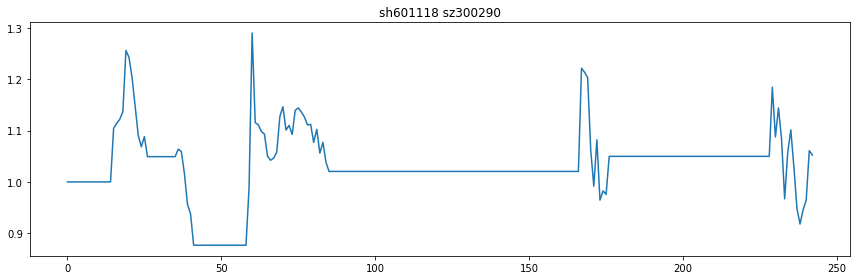

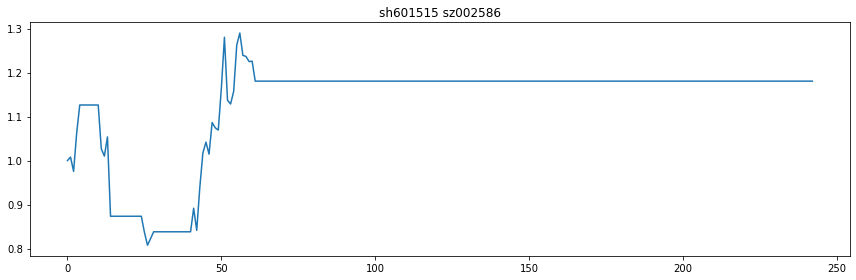

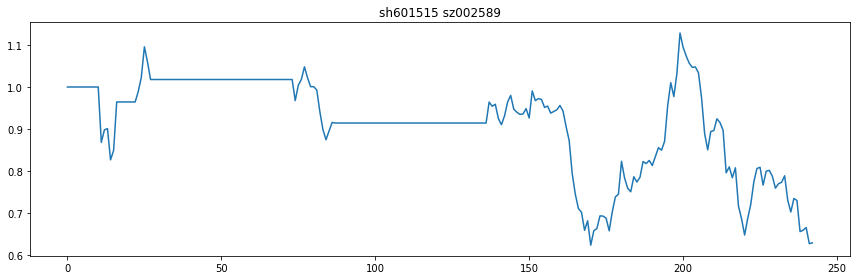

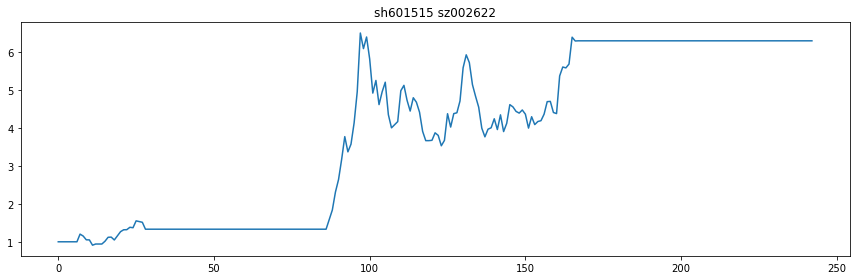

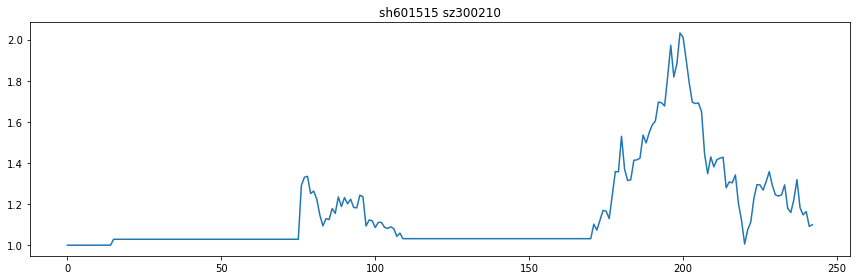

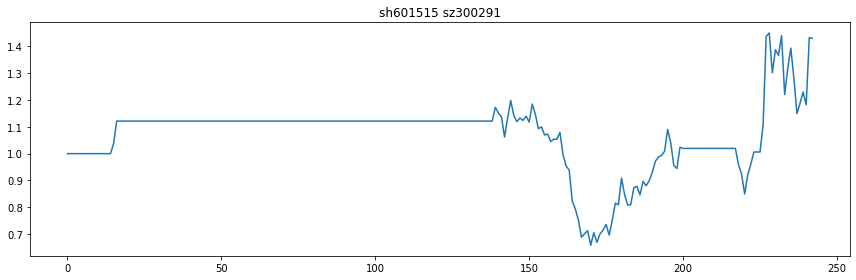

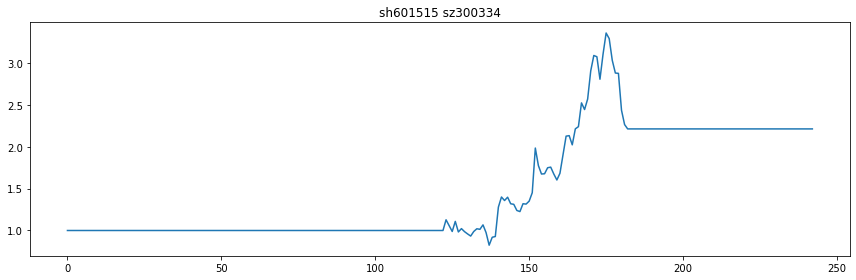

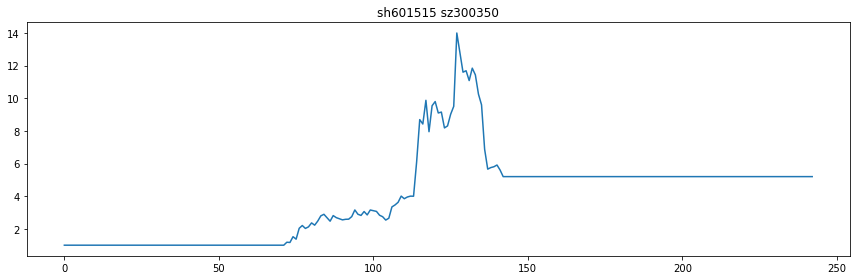

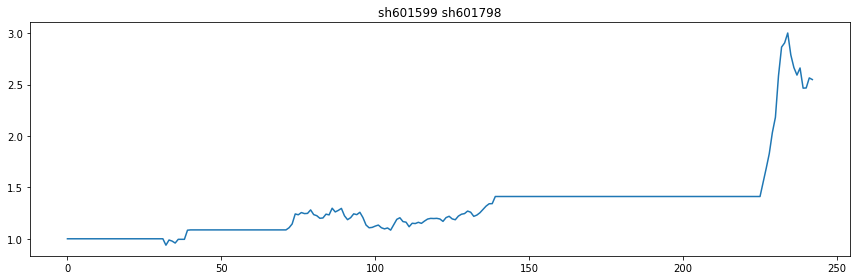

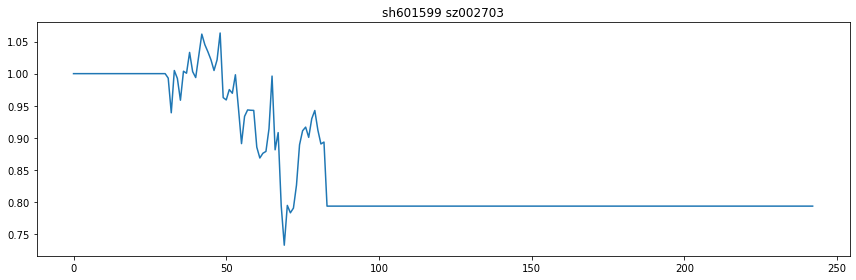

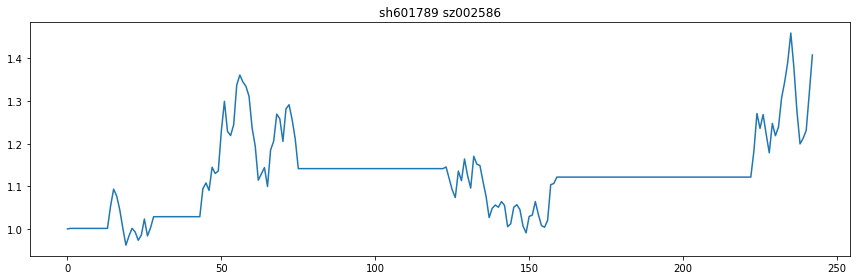

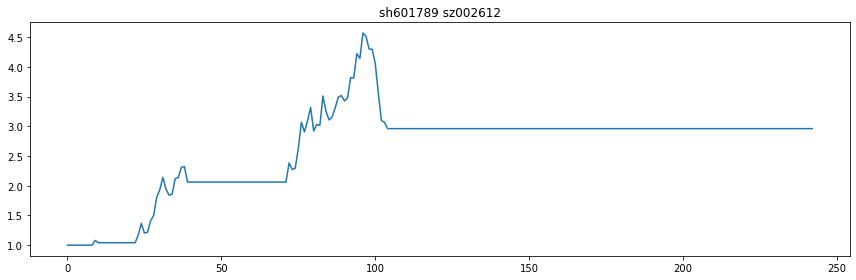

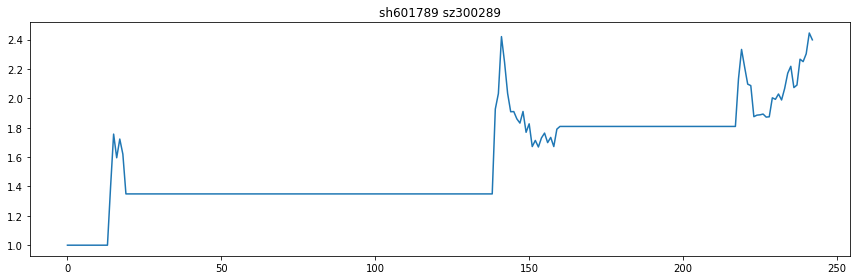

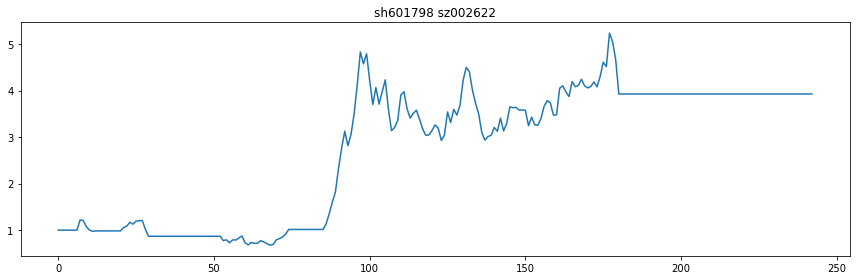

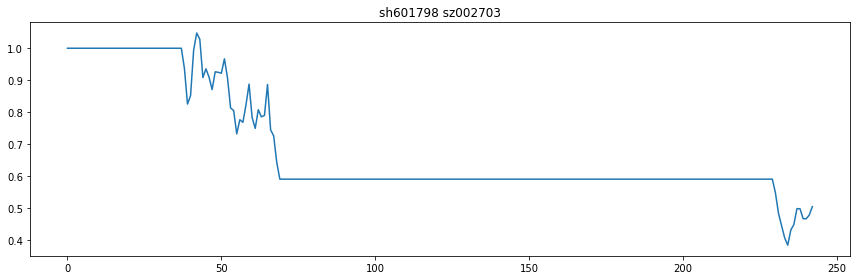

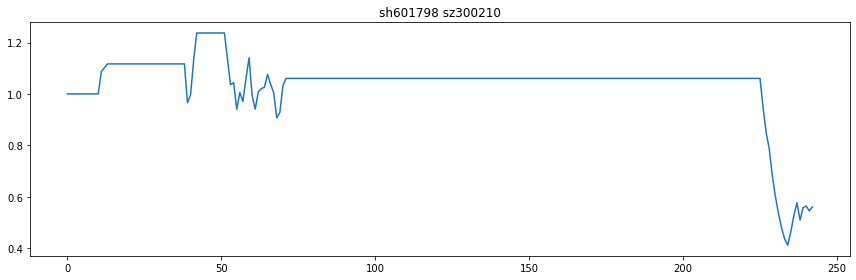

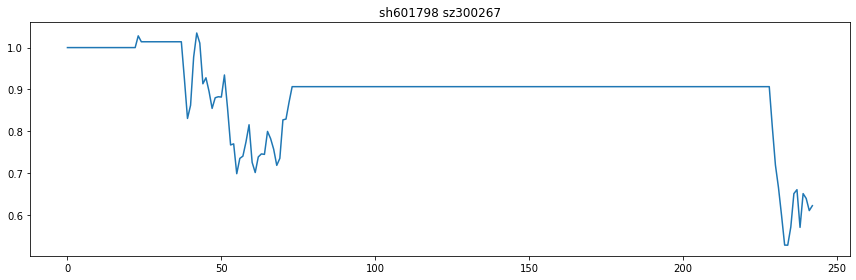

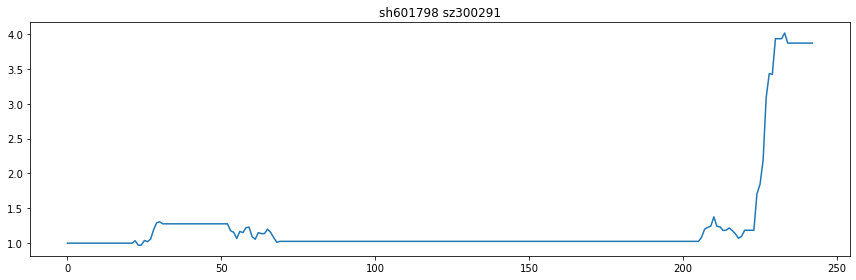

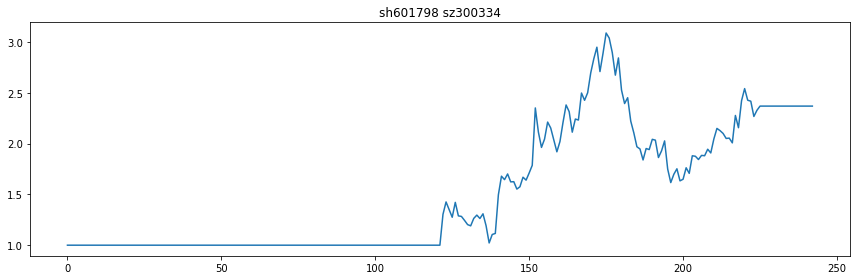

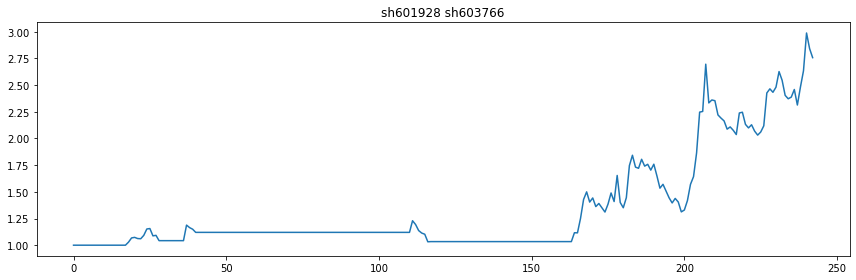

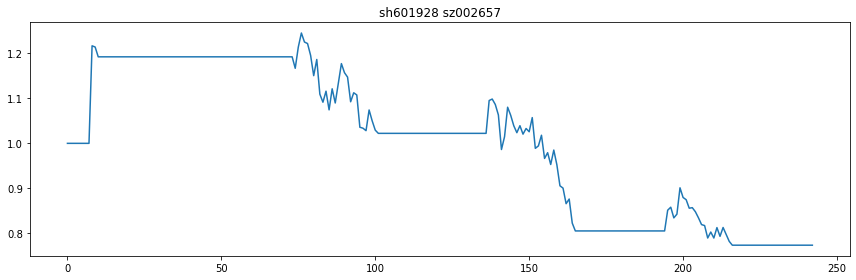

There were not some positions:


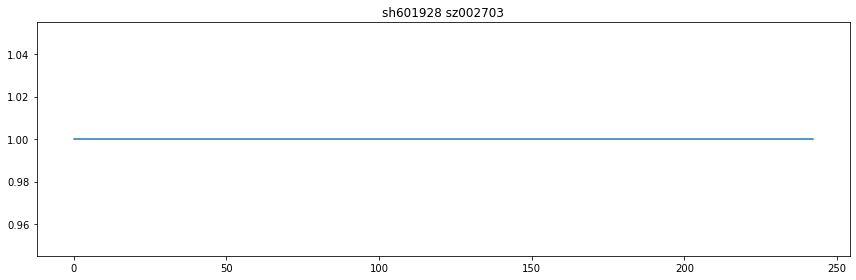

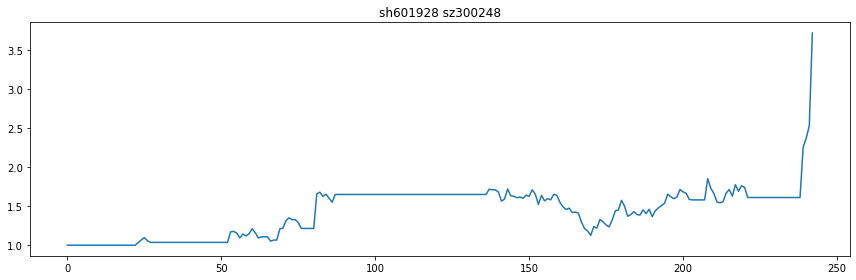

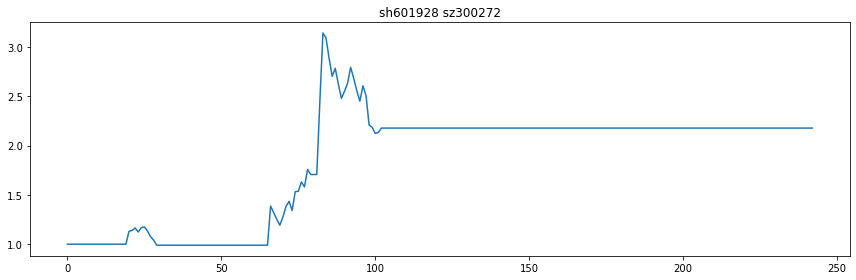

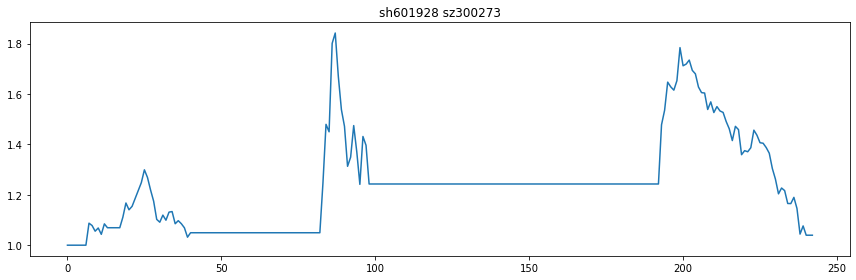

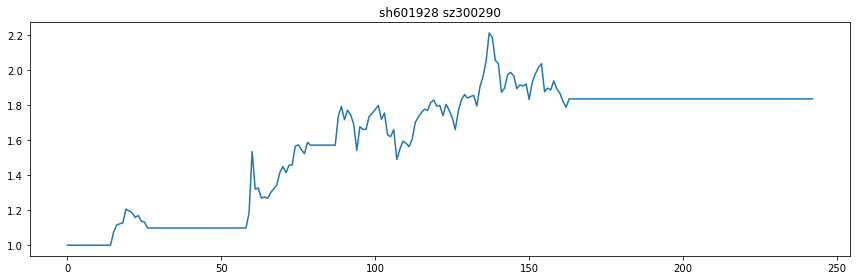

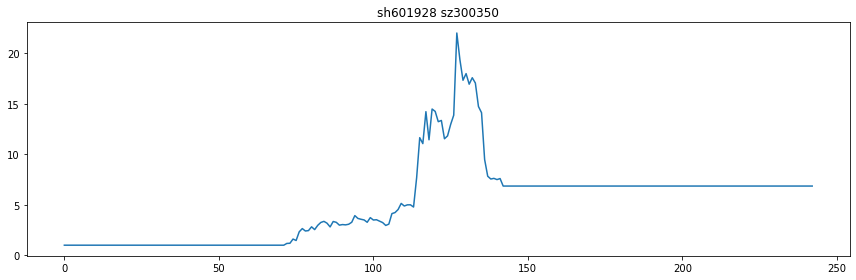

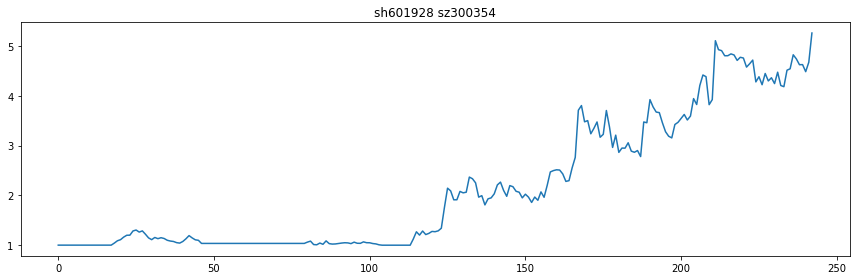

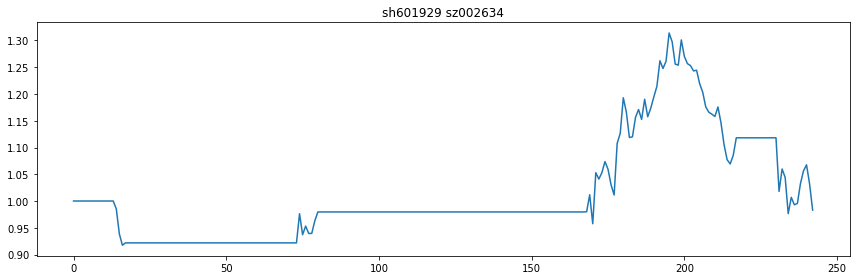

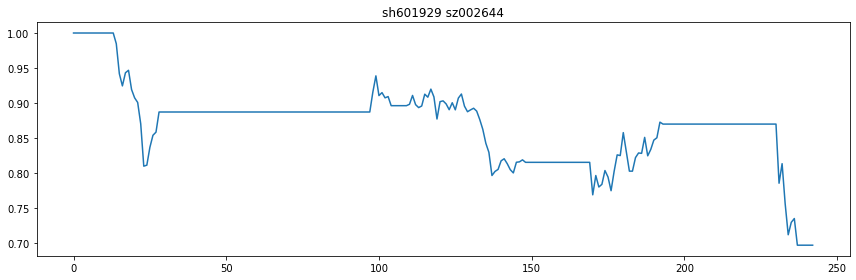

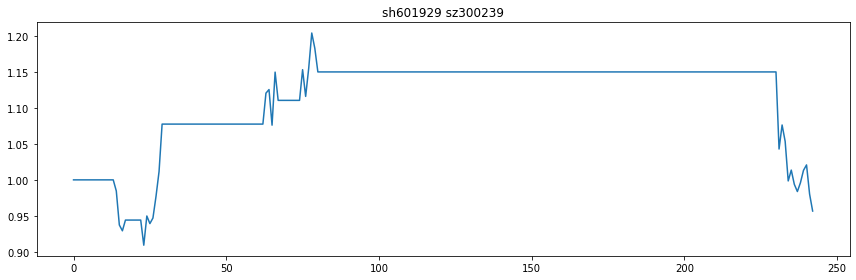

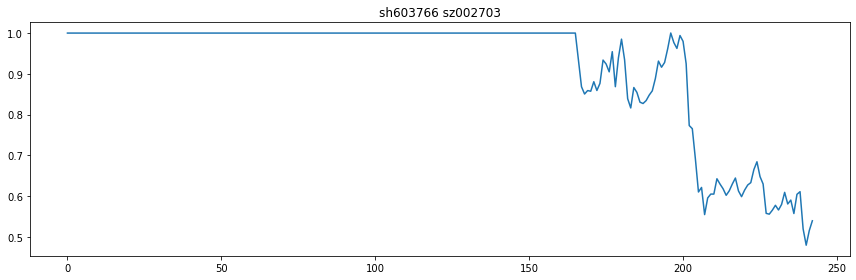

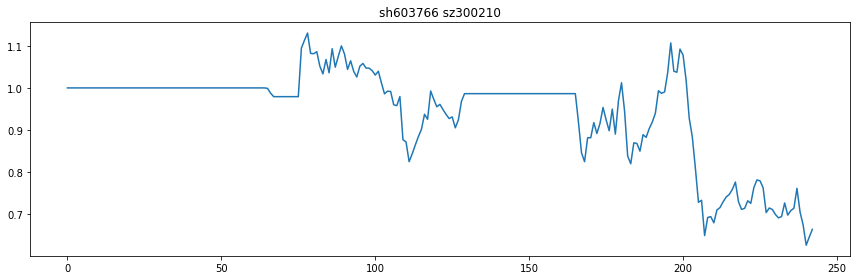

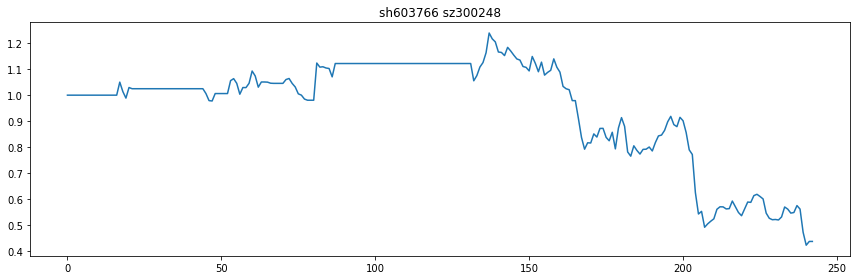

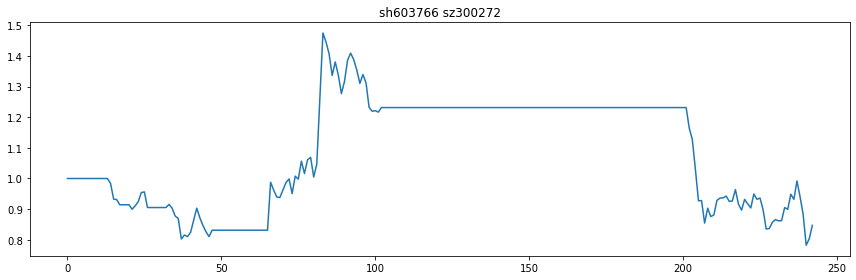

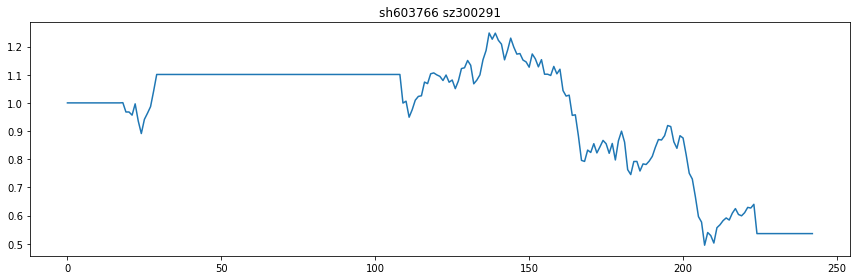

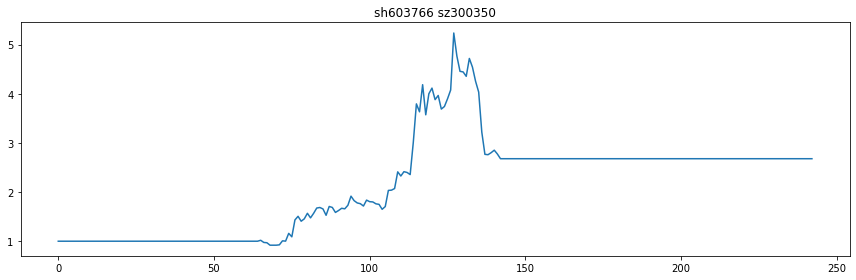

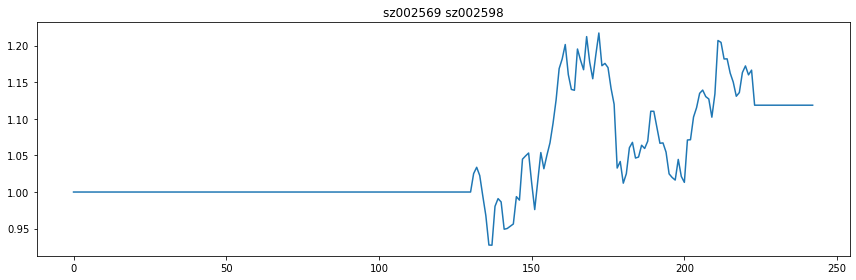

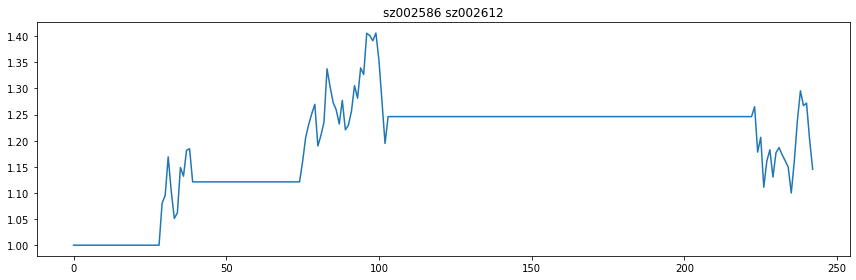

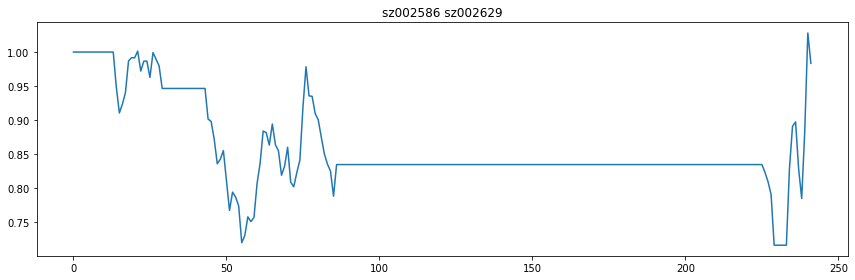

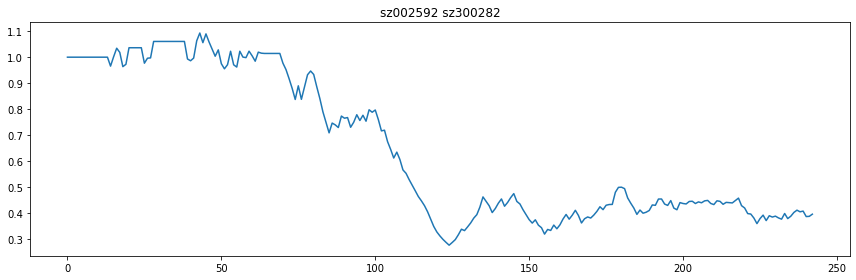

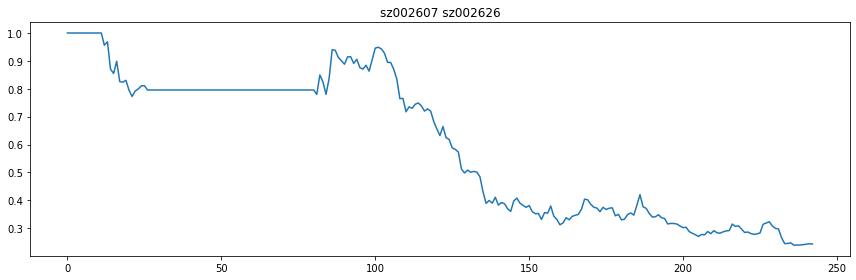

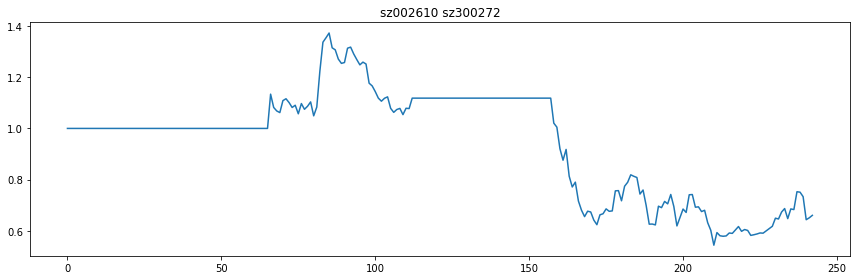

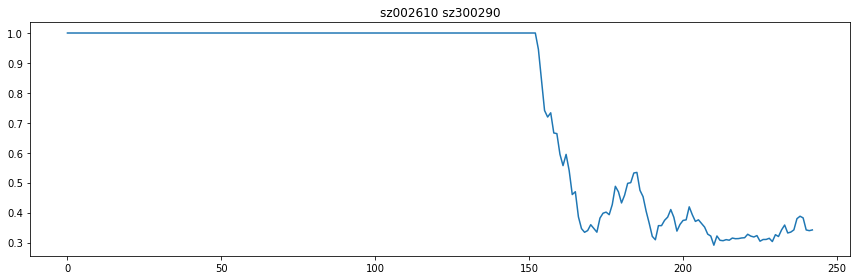

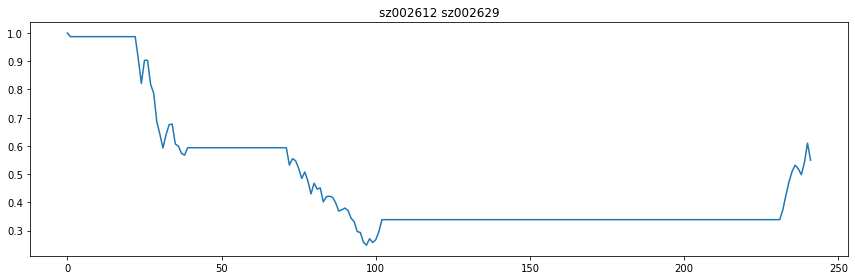

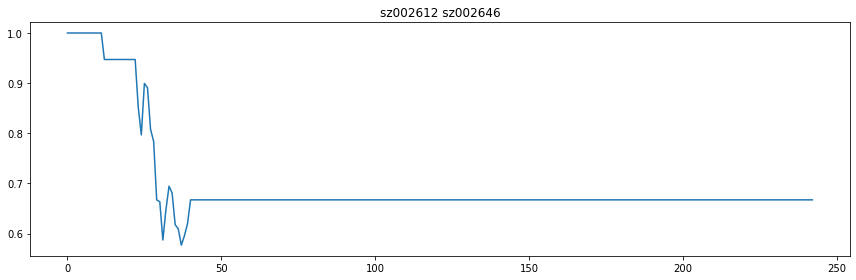

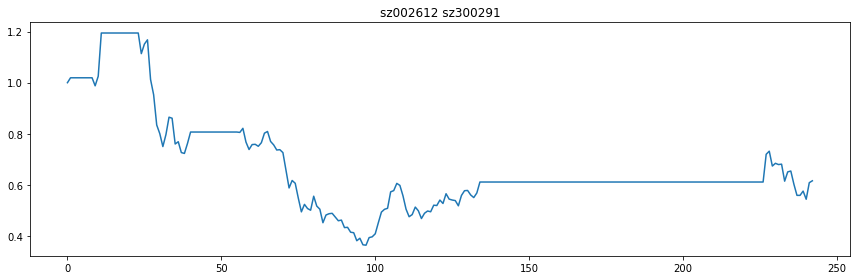

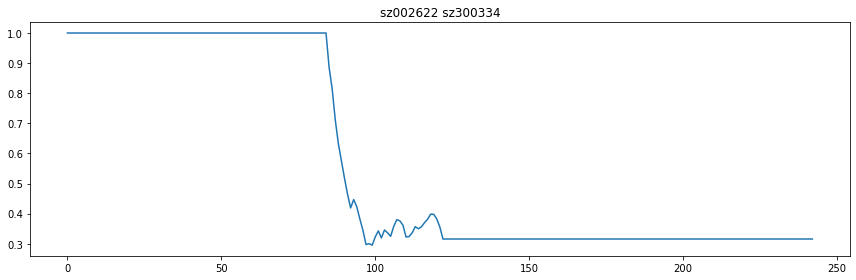

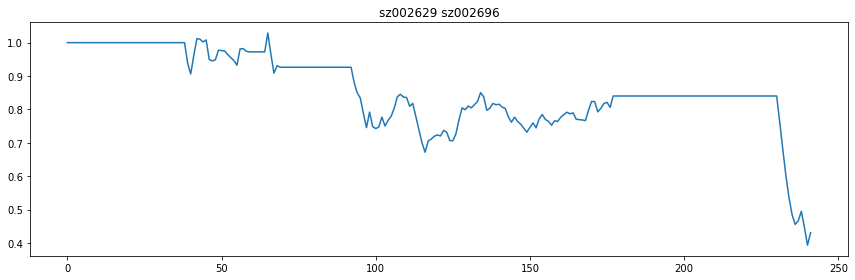

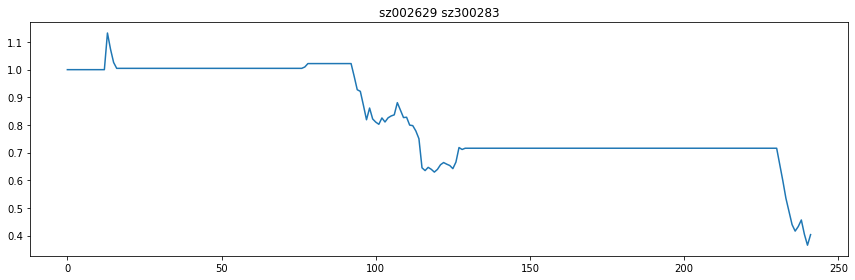

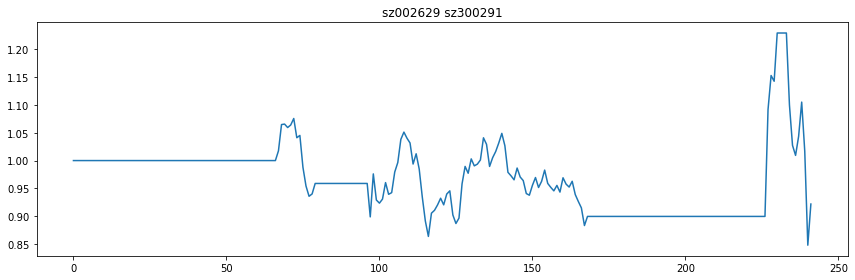

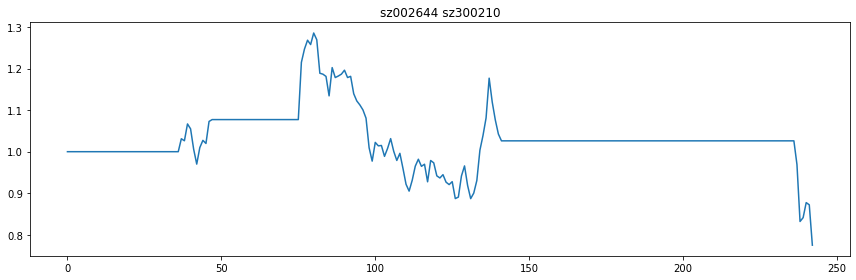

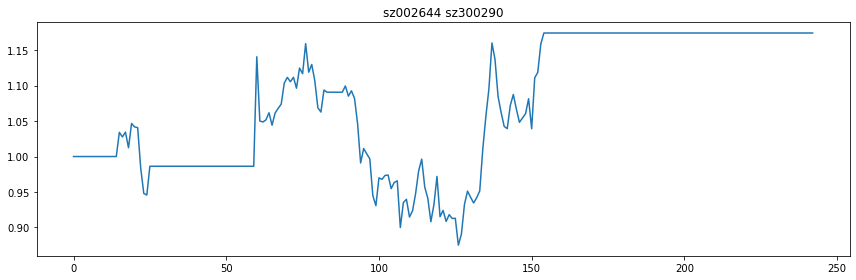

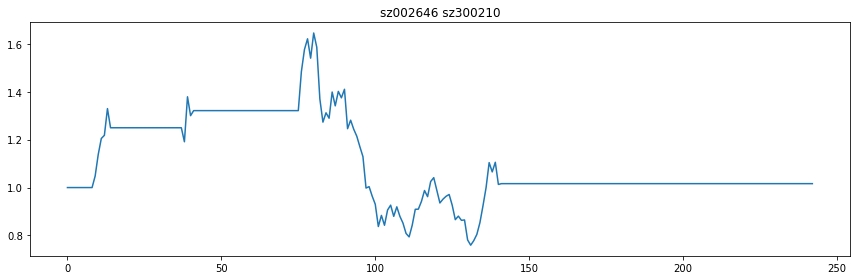

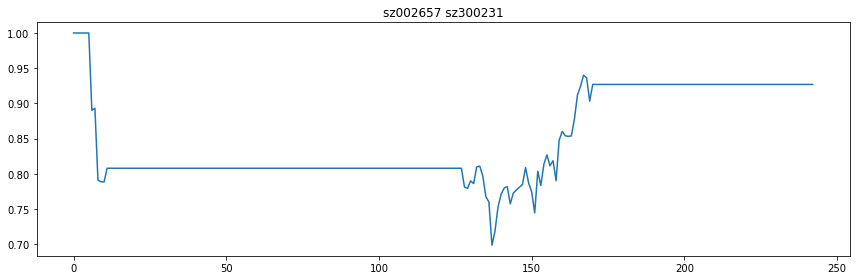

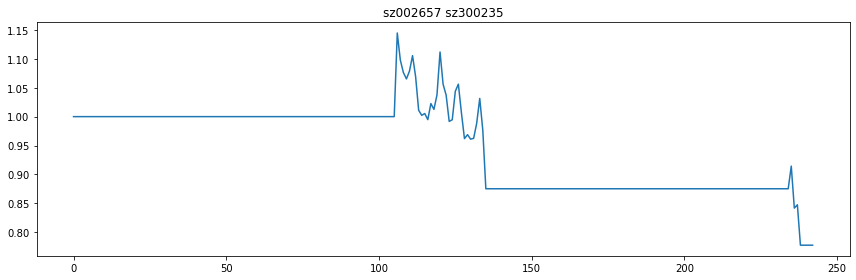

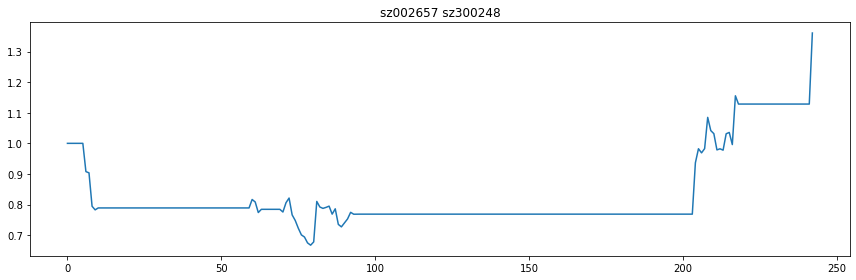

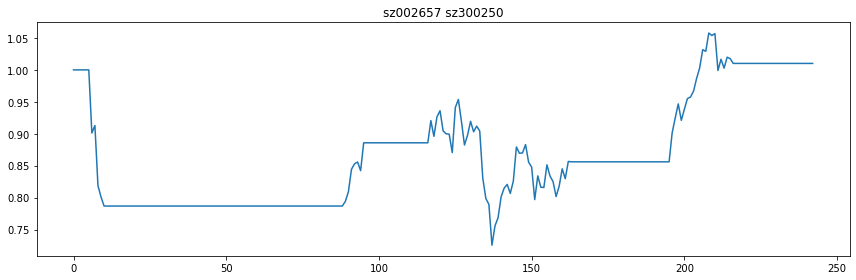

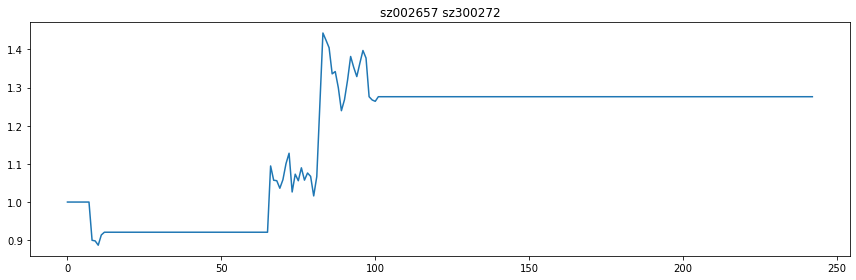

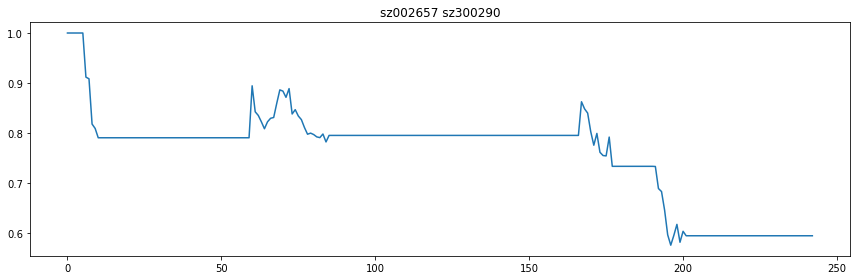

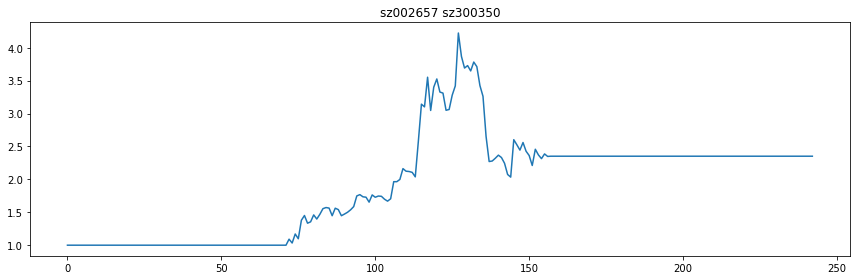

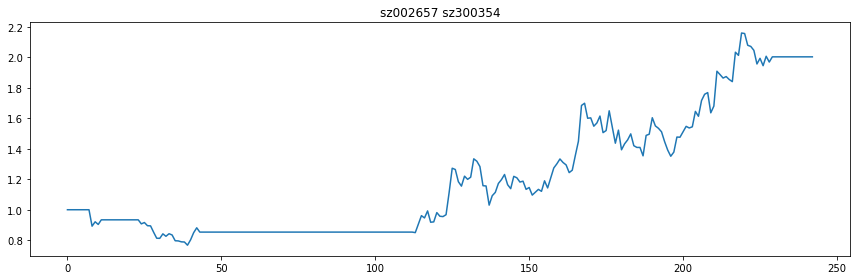

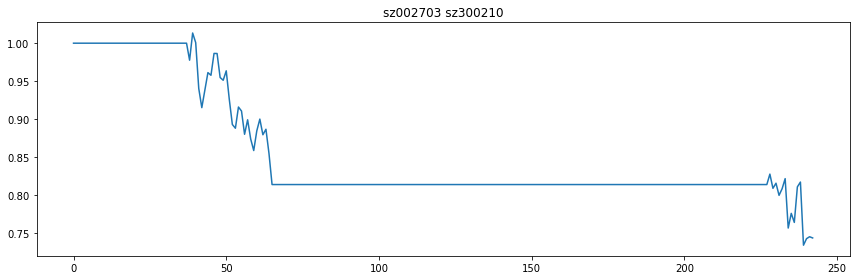

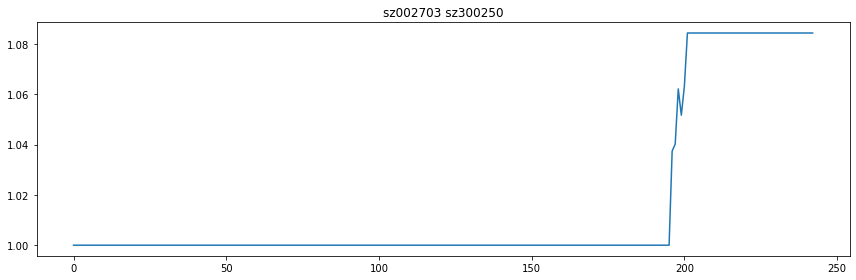

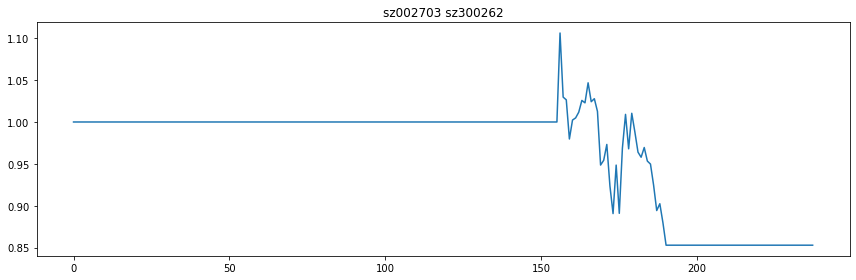

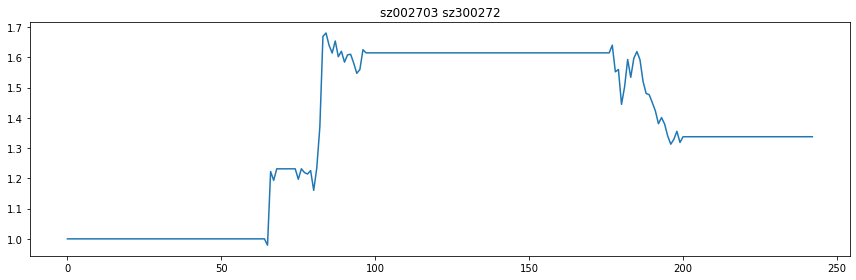

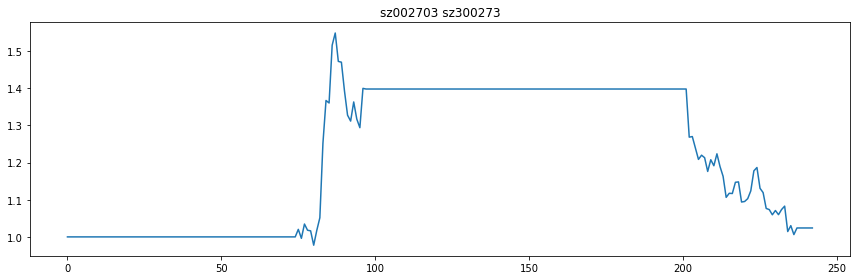

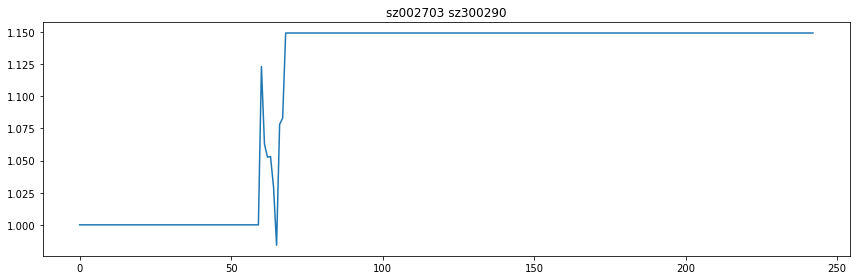

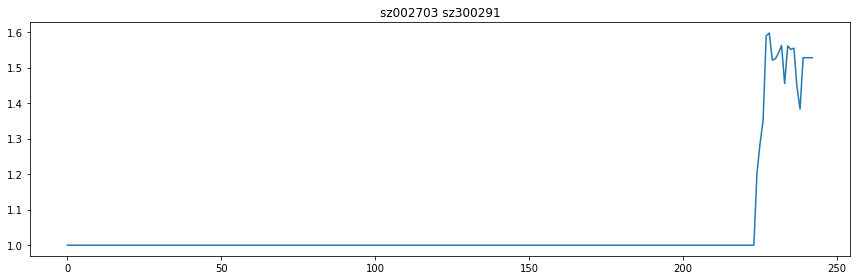

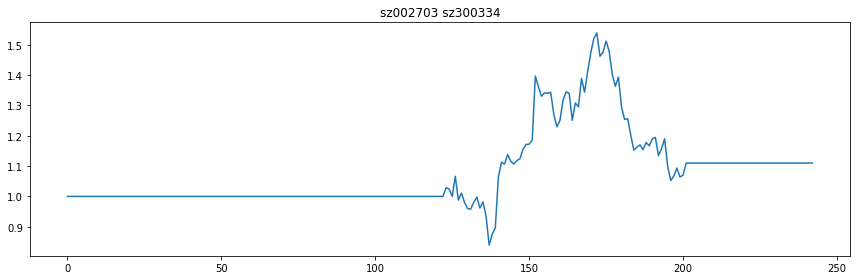

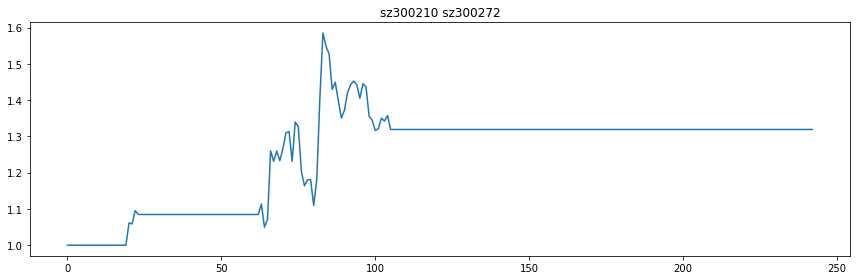

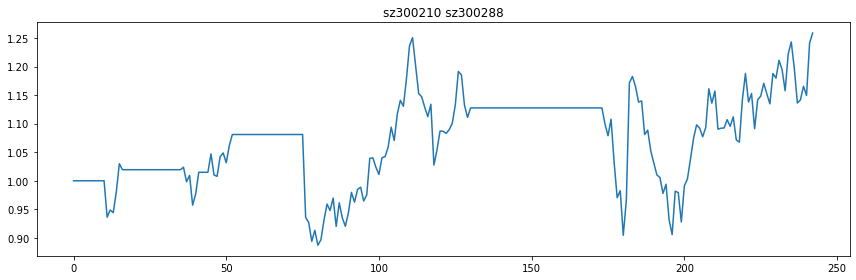

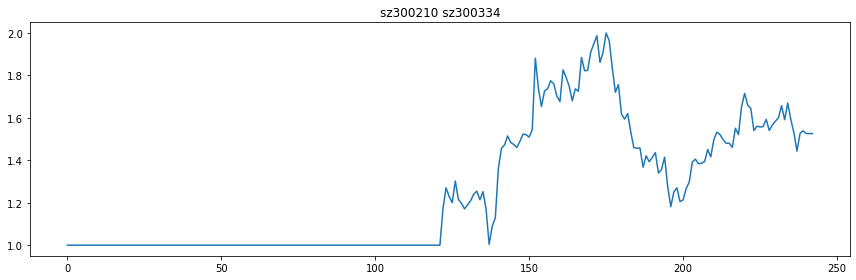

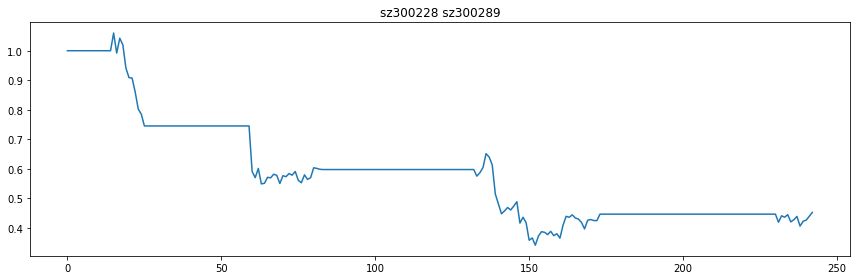

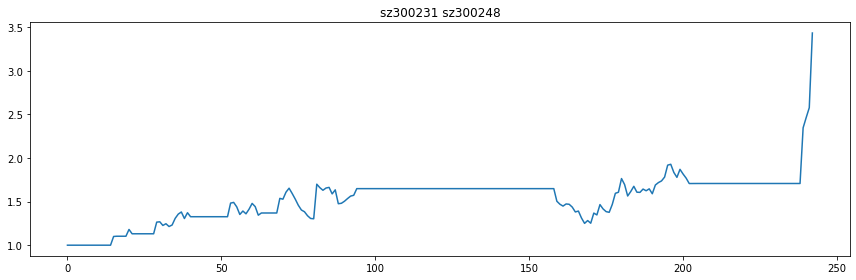

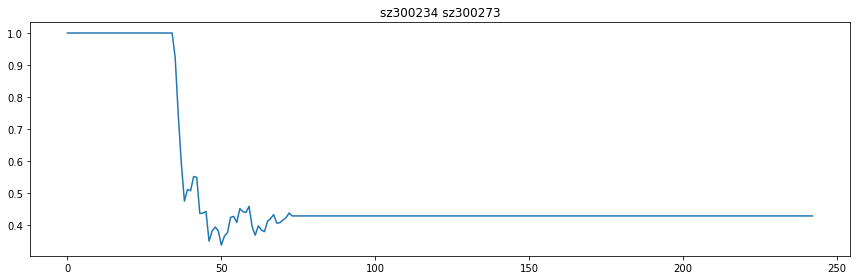

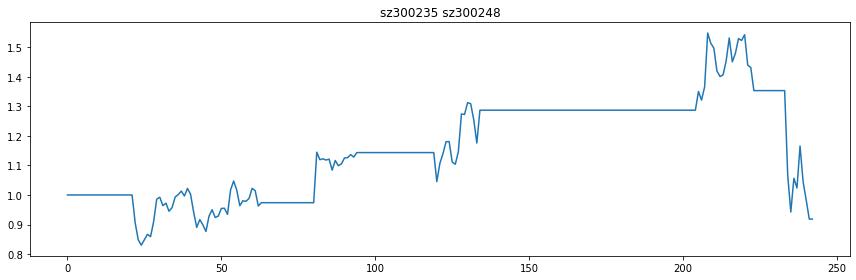

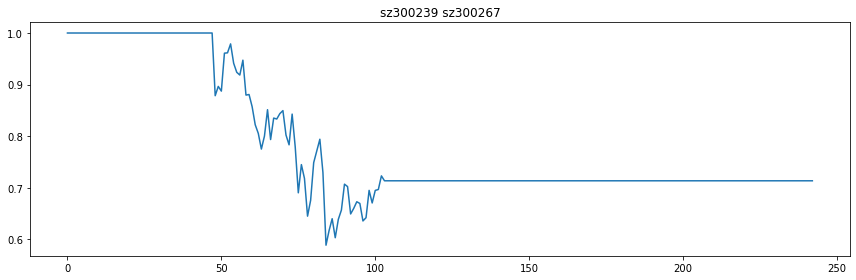

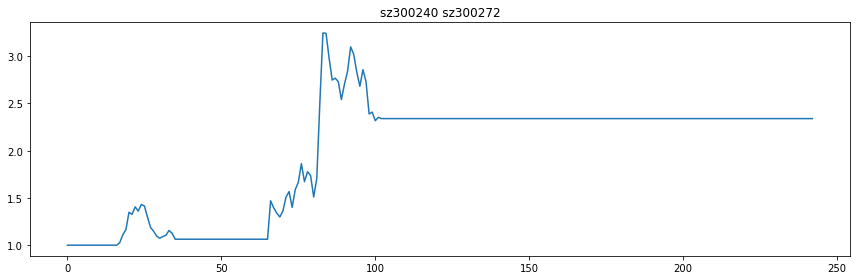

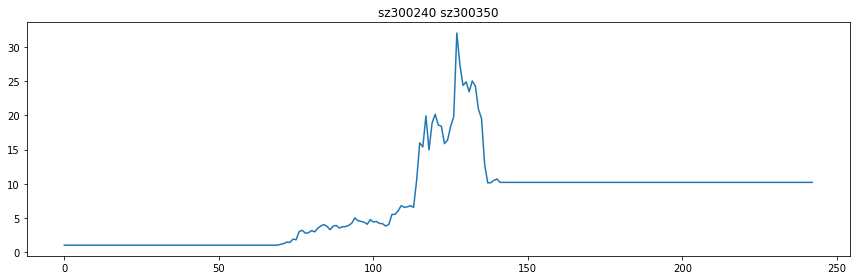

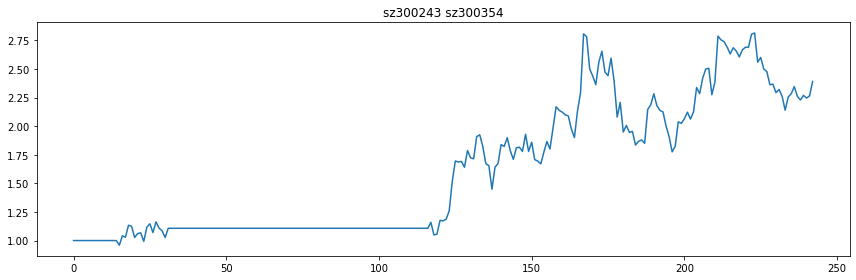

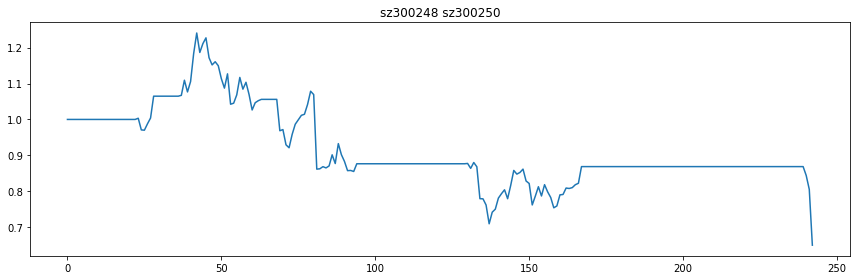

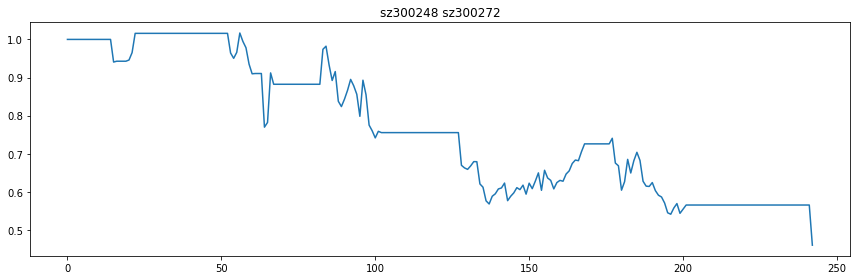

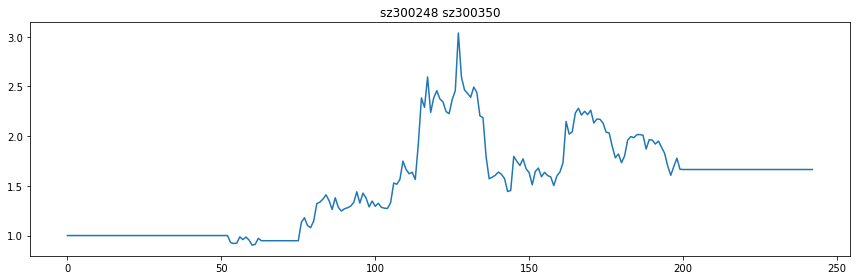

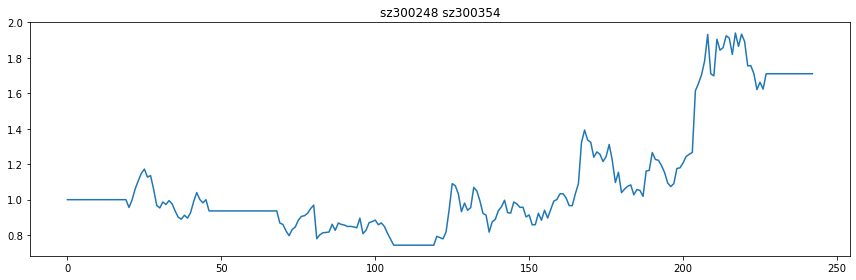

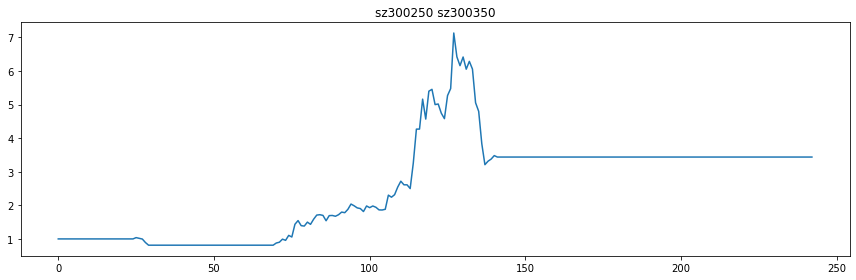

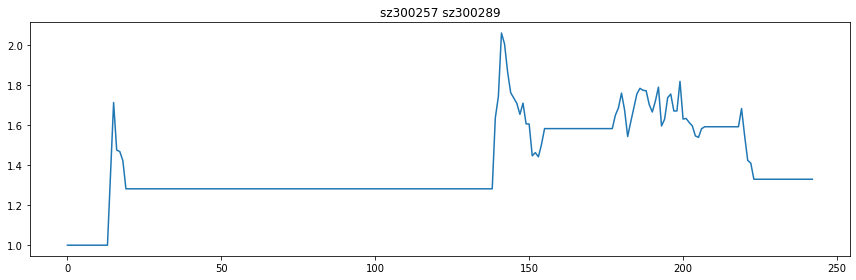

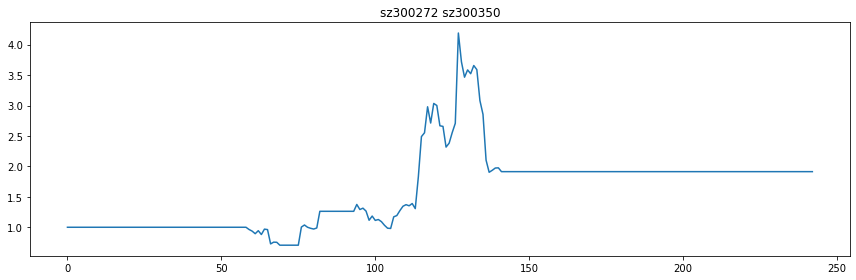

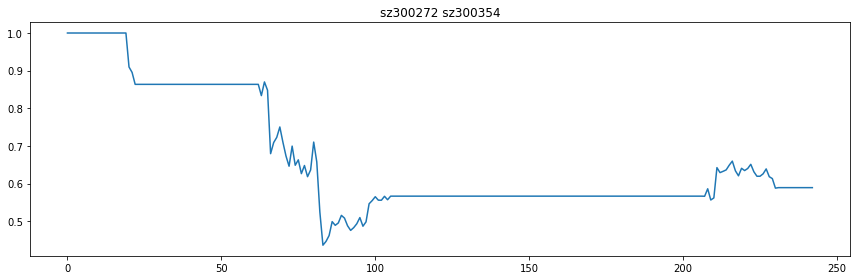

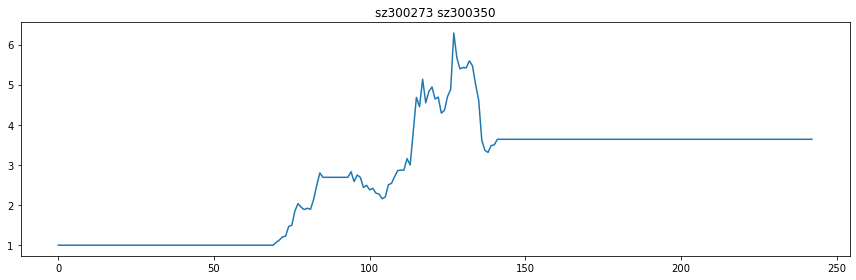

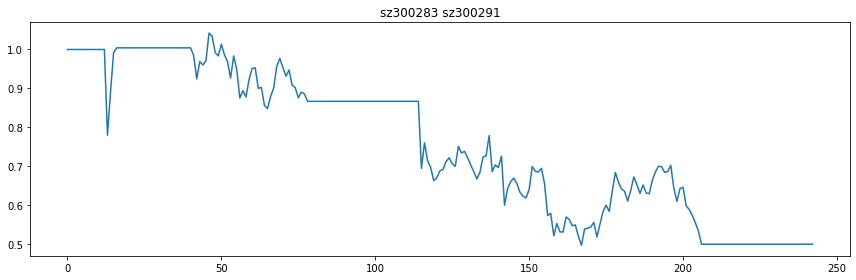

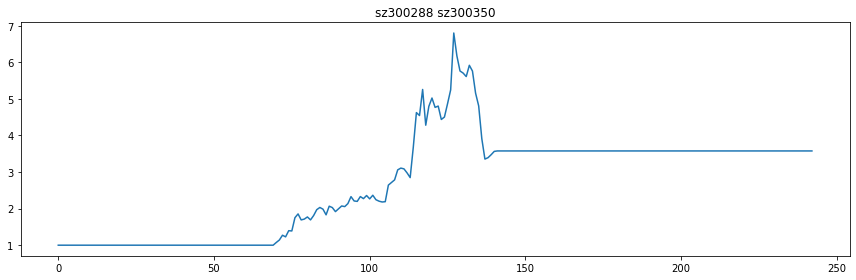

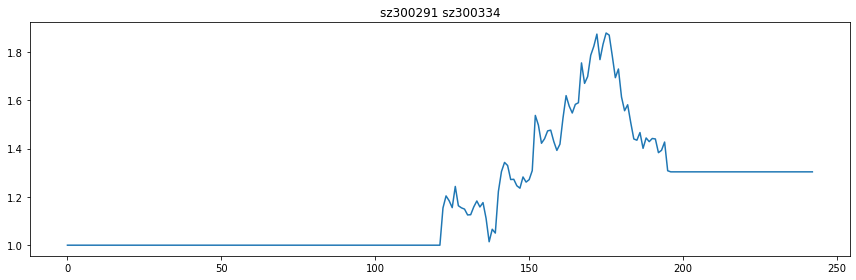

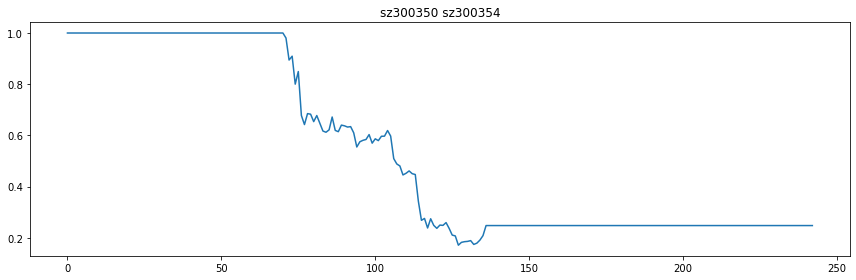

In [40]:
C = 0.005
pairs = result
pairs['Sharpe ratio'] = 0
pairs['MDD'] = 0
df_return = pd.DataFrame( {'date' : np.unique(test_data['date']) }) 
for i in range(pairs.shape[0]):
    p1 = test_data[test_data['ticker'] == pairs.loc[i]['ticker_1']]
    p2 = test_data[test_data['ticker'] == pairs.loc[i]['ticker_2']]
    p1 = pd.DataFrame( {'date' : p1['date'], 'adjusted' : p1['close'] * p1['qfq_factor'] } )
    p2 = pd.DataFrame( {'date' : p2['date'], 'adjusted' : p2['close'] * p2['qfq_factor'] } )

    merged = pd.merge(p1, p2, on = "date", suffixes = ('_p1', '_p2'))  

    if ( merged.size != 0 ):
        gamma = pairs.loc[i]['slope']
        eps_spread = np.log( merged['adjusted_p1'] ) - gamma * np.log( merged['adjusted_p2'] )
        
        #подсчет спреда
        expec_eps = eps_spread.rolling(len(eps_spread),min_periods=2).mean()
        expec_eps[0] = pairs.loc[i]['exp_eps']
        sd_eps = eps_spread.rolling(len(eps_spread),min_periods=2).std()
        sd_eps[0] = pairs.loc[i]['std_eps']   
        merged['spread'] = (eps_spread - expec_eps)/sd_eps

        #Открытие позиций 
        long_pos = False
        short_pos = False
        merged['position_1'] = merged['spread'].apply(make_short_pos_1) + merged['spread'].apply(make_long_pos_2)
        long_pos = False
        short_pos = False
        merged['position_2'] = merged['spread'].apply(make_short_pos_2) + merged['spread'].apply(make_long_pos_1)
        if (  pairs.loc[i]['correlation'] < 0 ):
            merged['position_1'] = (-1)*merged['position_1']
            merged['position_2'] = (-1)*merged['position_2']
        
        #Поправка цены на тразакционные издержки 
        merged['transaction_costs_1'] = C * np.append([0], np.diff(merged['position_1'])) + 1
        merged['transaction_costs_2'] = C * np.append([0], np.diff(merged['position_2'])) + 1
        merged['p1_with_transaction_costs'] = np.array(merged['transaction_costs_1'] * merged['adjusted_p1'])
        merged['p2_with_transaction_costs'] = np.array(merged['transaction_costs_2'] * merged['adjusted_p2'])
            
        #Подсчет доходности от "удержания" активов 
        return_1 = np.array(merged['p1_with_transaction_costs'])[1:]/np.array(merged['p1_with_transaction_costs'])[:-1]-1
        merged['return_1'] = np.append( [0], return_1)
        return_2 = np.array(merged['p2_with_transaction_costs'][1:])/np.array(merged['p2_with_transaction_costs'][:-1])-1
        merged['return_2'] = np.append( [0], return_2)
        
        #Подсчет доходности внутри позиции 
        merged['profit_1'] = merged['return_1'] * merged['position_1'] + 1 
        merged['profit_2'] = merged['return_2'] * merged['position_2'] + 1 
    
        #Подсчет доходности стратегии
        merged['return_raw'] = np.log( merged['profit_1'] ) - gamma * np.log( merged['profit_2'] ) 
        merged['simple_return'] = np.exp(merged['return_raw'])
    
        #Занесем данные о прибыли в датасет df_return 
        df_return = df_return.merge( merged[['date', 'simple_return']], on = 'date')
        
        #Подсчет показателей стратегии
        if( np.std(merged['simple_return']-1) != 0 ):
            sharpe_ratio = np.mean(merged['simple_return']-1)/np.std(merged['simple_return']-1)
            sharpe_ratio_y = sharpe_ratio * np.sqrt(252)
            MDD = max( np.maximum.accumulate( merged['simple_return'] - 1) -  ( merged['simple_return'] - 1 ) )
        else:
            print('There were not some positions:' )
        
        #Занесем результаты в датафрейм
        pairs.loc[i,'Sharpe ratio'] = sharpe_ratio_y
        pairs.loc[i,'MDD'] = MDD

        plt.plot( np.cumprod(merged['simple_return']))
        plt.title(pairs.loc[i]['ticker_1'] + ' ' + pairs.loc[i]['ticker_2'] )
        plt.show()                           

#### Визуализируем соответствие между показателем Шарпа и максимальной просадкой

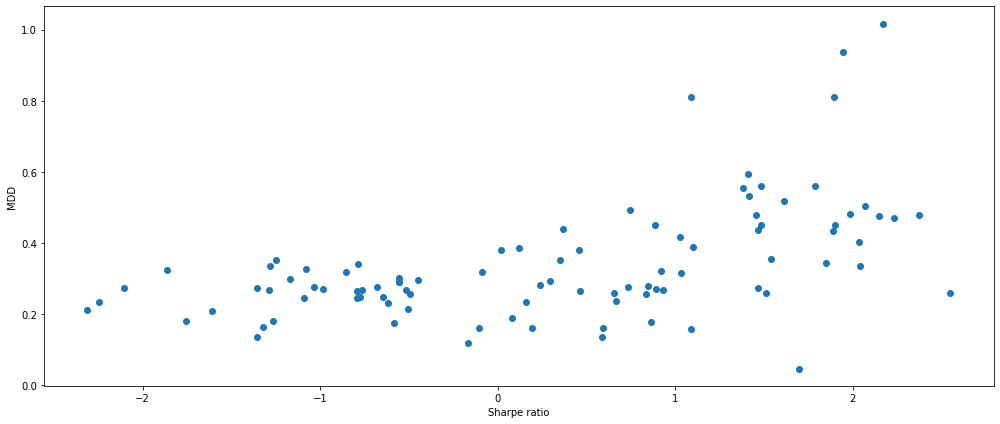

In [43]:
plt.rcParams["figure.figsize"] = [14.00, 6]
plt.xlabel('Sharpe ratio')
plt.ylabel('MDD')
plt.rcParams["figure.autolayout"] = True
plt.plot(pairs['Sharpe ratio'], pairs['MDD'], 'o')
plt.show()

#### Далее будем подбирать наиболее оптимальный набор пар.  Коэффициент Шарпа и максимальную просадку для каждого набора будем сохранять в result_ret

In [44]:
result_ret = pd.DataFrame( np.empty( ( 0, 4 ) ) )
result_ret.columns = {'i_value', 'j_value', 'sharpe', 'MDD'}
for  i in range(11) :
    for  j in range(4) :
        temp_data = pairs[ pairs['Sharpe ratio'] >= 2.5 - i * 0.1 ]
        temp_data = temp_data[ temp_data['MDD'] <= 0.3 + j * 0.05]
        
        temp_return_data = df_return.iloc[:, temp_data.index + 1 ] - 1
        temp_return_data['R'] = 1 / temp_data.index.size * ( temp_return_data.sum( axis = 1) ) + 1
   
        #Рассчитываем коэффициенты
        sharpe_ratio = np.mean(temp_return_data['R'] - 1)/np.std(temp_return_data['R'] - 1)
        sharpe_ratio_y = sharpe_ratio * np.sqrt(252)
        MDD = max( np.maximum.accumulate(temp_return_data['R'] - 1 ) -  ( temp_return_data['R'] - 1 ) )
        
        #Сделать append
        result_ret = result_ret.append({'i_value': i, 'j_value': j, 'sharpe': sharpe_ratio_y, 'MDD': MDD}, ignore_index=True)
        
        
        

In [45]:
result_ret

i_value    sharpe  j_value       MDD
0       0.0  2.360297      0.0  0.185481
1       0.0  2.360297      1.0  0.185481
2       0.0  2.360297      2.0  0.185481
3       0.0  2.360297      3.0  0.185481
4       1.0  2.360297      0.0  0.185481
5       1.0  2.360297      1.0  0.185481
6       1.0  2.360297      2.0  0.185481
7       1.0  2.360297      3.0  0.185481
8       2.0  2.360297      0.0  0.185481
9       2.0  2.360297      1.0  0.185481
10      2.0  2.360297      2.0  0.185481
11      2.0  2.360297      3.0  0.185481
12      3.0  2.360297      0.0  0.185481
13      3.0  2.360297      1.0  0.185481
14      3.0  2.360297      2.0  0.185481
15      3.0  2.360297      3.0  0.185481
16      4.0  2.360297      0.0  0.185481
17      4.0  2.360297      1.0  0.185481
18      4.0  2.360297      2.0  0.185481
19      4.0  2.360297      3.0  0.185481
20      5.0  2.360297      0.0  0.185481
21      5.0  2.986169      1.0  0.180608
22      5.0  2.986169      2.0  0.180608
23      5.0  3.591559      3.0  0.161702
24      6.0  2.360297      0.0  0.185481
25      6.0  2.986169      1.0  0.180608
26      6.0  2.986169      2.0  0.180608
27      6.0  3.591559      3.0  0.161702
28      7.0  2.360297      0.0  0.185481
29      7.0  3.363112      1.0  0.125938
30      7.0  3.363112      2.0  0.125938
31      7.0  4.441518      3.0  0.155781
32      8.0  2.360297      0.0  0.185481
33      8.0  3.363112      1.0  0.125938
34      8.0  3.363112      2.0  0.125938
35      8.0  4.441518      3.0  0.155781
36      9.0  2.575422      0.0  0.092741
37      9.0  3.445125      1.0  0.094454
38      9.0  3.445125      2.0  0.094454
39      9.0  4.491246      3.0  0.133527
40     10.0  2.728482      0.0  0.084265
41     10.0  3.690918      1.0  0.086348
42     10.0  3.346905      2.0  0.127557
43     10.0  4.665026      3.0  0.105943

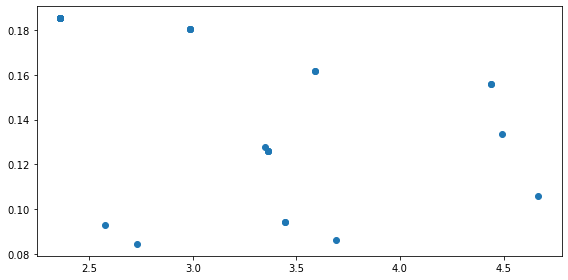

In [46]:
plt.rcParams["figure.figsize"] = [8.00, 4]
plt.rcParams["figure.autolayout"] = True
plt.plot( result_ret['sharpe'], result_ret['MDD'], 'o')
plt.show()

#### Точка, соответствующая наиболее оптимальному набору ближе к правому нижнему углу. Можно заметить, что она соответвует последней строке датафрейма result_ret

In [47]:
i = 10 
j = 3
temp_data = pairs[ pairs['Sharpe ratio'] >= 2.5 - i * 0.1 ]
temp_data = temp_data[ temp_data['MDD'] <= 0.3 + j * 0.05]
pairs = temp_data[['ticker_1', 'ticker_2', 'correlation', 'slope', 'exp_eps', 'std_eps']]
pairs.index = np.arange(len(pairs))
pairs

ticker_1  ticker_2  correlation     slope   exp_eps   std_eps
0  sh601599  sh601798     0.816407  0.703968  0.189697  0.269333
1  sh601789  sz002612     0.831861  1.388416 -2.151662  0.454039
2  sh601798  sz002622     0.818021  1.436235 -0.682994  0.643857
3  sh601928  sh603766     0.886062  1.672137 -1.174857  0.700723
4  sh601928  sz300248     0.855096  1.581989 -1.859812  0.643565
5  sz002657  sz300354     0.936600  0.645986  1.502870  0.349803
6  sz002703  sz300250     0.814146  0.523105  0.820807  0.516227
7  sz300231  sz300248     0.925443  1.251259 -0.814442  0.331260
8  sz300243  sz300354     0.818411  0.739127  0.241974  0.270594

#### Производим финальный расчет результатов модели аналогично тому, как делали это на тестовой выборке

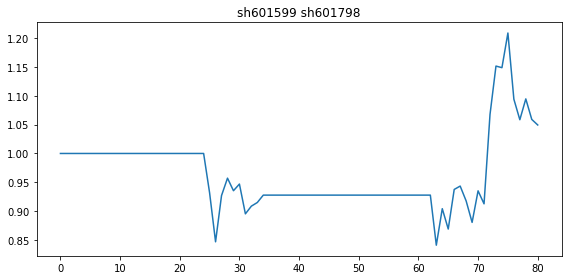

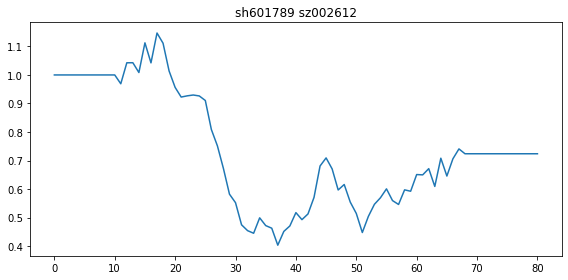

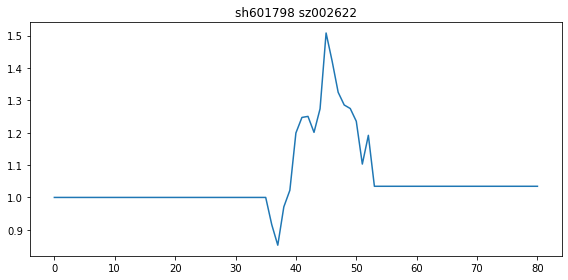

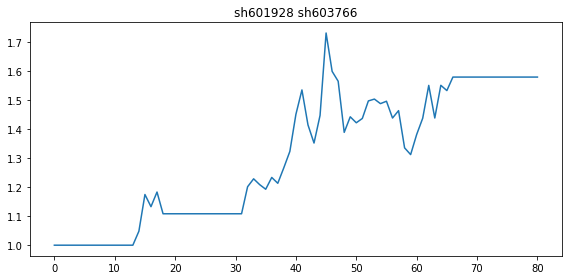

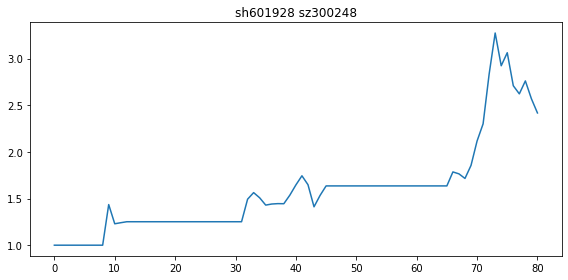

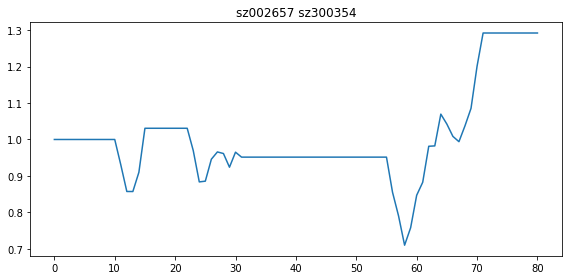

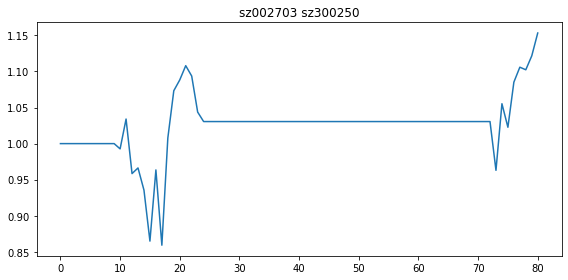

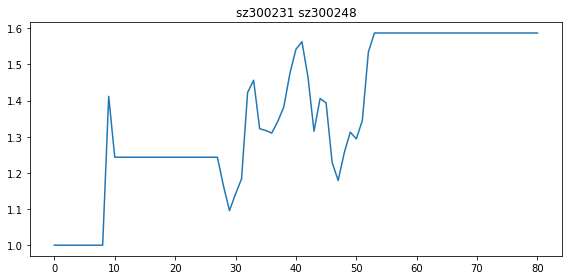

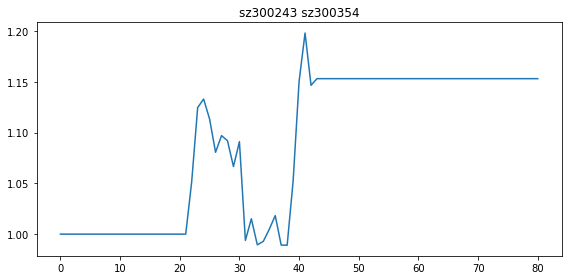

In [48]:
C = 0.005
df_return = pd.DataFrame( {'date' : np.unique(final_data['date']) }) 

for i in range(pairs.shape[0]):
    p1 = final_data[final_data['ticker'] == pairs.loc[i]['ticker_1']]
    p2 = final_data[final_data['ticker'] == pairs.loc[i]['ticker_2']]
    p1 = pd.DataFrame( {'date' : p1['date'], 'adjusted' : p1['close'] * p1['qfq_factor'] } )
    p2 = pd.DataFrame( {'date' : p2['date'], 'adjusted' : p2['close'] * p2['qfq_factor'] } )

    merged = pd.merge(p1, p2, on = "date", suffixes = ('_p1', '_p2'))  

    if ( merged.size != 0 ):
        gamma = pairs.loc[i]['slope']
        eps_spread = np.log( merged['adjusted_p1'] ) - gamma * np.log( merged['adjusted_p2'] )
        
        #подсчет спреда
        expec_eps = eps_spread.rolling(len(eps_spread),min_periods=2).mean()
        expec_eps[0] = pairs.loc[i]['exp_eps']
        sd_eps = eps_spread.rolling(len(eps_spread),min_periods=2).std()
        sd_eps[0] = pairs.loc[i]['std_eps']   
        merged['spread'] = (eps_spread - expec_eps)/sd_eps

        #Открытие позиций 
        long_pos = False
        short_pos = False
        merged['position_1'] = merged['spread'].apply(make_short_pos_1) + merged['spread'].apply(make_long_pos_2)
        long_pos = False
        short_pos = False
        merged['position_2'] = merged['spread'].apply(make_short_pos_2) + merged['spread'].apply(make_long_pos_1)
        if (  pairs.loc[i]['correlation'] < 0 ):
            merged['position_1'] = (-1)*merged['position_1']
            merged['position_2'] = (-1)*merged['position_2']
        
        #Поправка цены на тразакционные издержки 
        merged['transaction_costs_1'] = C * np.append([0], np.diff(merged['position_1'])) + 1
        merged['transaction_costs_2'] = C * np.append([0], np.diff(merged['position_2'])) + 1
        merged['p1_with_transaction_costs'] = np.array(merged['transaction_costs_1'] * merged['adjusted_p1'])
        merged['p2_with_transaction_costs'] = np.array(merged['transaction_costs_2'] * merged['adjusted_p2'])
            
        #Подсчет доходности от "удержания" активов 
        return_1 = np.array(merged['p1_with_transaction_costs'])[1:]/np.array(merged['p1_with_transaction_costs'])[:-1]-1
        merged['return_1'] = np.append( [0], return_1)
        return_2 = np.array(merged['p2_with_transaction_costs'][1:])/np.array(merged['p2_with_transaction_costs'][:-1])-1
        merged['return_2'] = np.append( [0], return_2)
        
        #Подсчет доходности внутри позиции 
        merged['profit_1'] = merged['return_1'] * merged['position_1'] + 1 
        merged['profit_2'] = merged['return_2'] * merged['position_2'] + 1 
    
        #Подсчет доходности стратегии
        merged['return_raw'] = np.log( merged['profit_1'] ) - gamma * np.log( merged['profit_2'] ) 
        merged['simple_return'] = np.exp(merged['return_raw'])
    
        #Занесем данные о прибыли в датасет df_return 
        df_return = df_return.merge( merged[['date', 'simple_return']], on = 'date')
        
        plt.plot( np.cumprod(merged['simple_return']))
        plt.title(pairs.loc[i]['ticker_1'] + ' ' + pairs.loc[i]['ticker_2'] )
        plt.show()                           

## Подводим итоги.

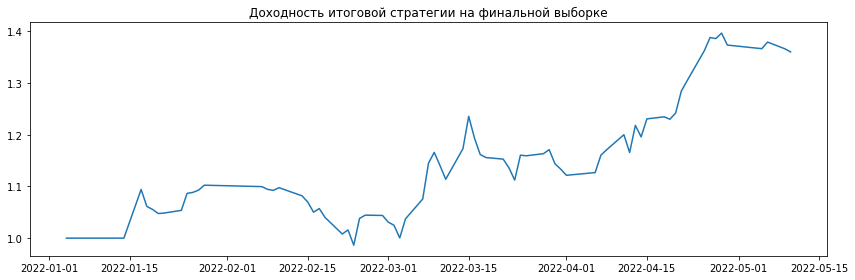

Итоговая доходность 36.020402711152165 %
Показатель Шарпа 2.742152326366516
Максимальная просадка 12.815710444436924 %


In [49]:
temp_return_data = df_return.iloc[:, 1:] - 1
temp_return_data['R'] = 1 / temp_data.index.size * ( temp_return_data.sum( axis = 1) ) + 1


plt.rcParams["figure.figsize"] = [12.00, 4]
plt.title("Доходность итоговой стратегии на финальной выборке")
plt.plot(df_return['date'], np.cumprod(temp_return_data['R']) )
plt.show()
print("Итоговая доходность", (np.cumprod(temp_return_data['R'])[ np.cumprod(temp_return_data['R']).size-1] - 1)*100, "%" )
sharpe_ratio = np.mean(temp_return_data['R'] - 1)/np.std(temp_return_data['R'] - 1)
sharpe_ratio_y = sharpe_ratio * np.sqrt(252)
print("Показатель Шарпа", sharpe_ratio_y)
MDD = max( np.maximum.accumulate(temp_return_data['R'] - 1 ) -  ( temp_return_data['R'] - 1 ) )
print("Максимальная просадка", MDD * 100, "%")
